## Import Libraries <a id='import_libraries'><a>

In [1]:
import pandas as pd
from utils import (show_missing_values,
                    impute_mmm, 
                    plot_top_categories,
                    plot_histogram,
                    show_outliers,
                    show_mar_relation,
                    impute_random)
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Default Settings <a id='default_settings'><a>

In [2]:
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
healthy_orange = '#EC6602'
healthy_orange_25 = '#FDDDCB'
siemens_petrol = '#009999'
siemens_petrol_50 = '#87D2D2'
sns.set_palette([healthy_orange, siemens_petrol, healthy_orange_25, siemens_petrol_50])
RANDOM_SEED = 42

## Import Data  <a id='import_data'><a>

In [3]:
df = pd.read_csv('data/Crime_Data_from_2020_to_Present.csv')
df_mocode = pd.read_csv('data/mocodes.csv')

### Drop Duplicates

- Duplicated rows have no meaning in a dataset, so it is better to remove them at the beginning 
without even looking at the data

In [4]:
df = df.drop_duplicates()

## EDA

- try to understand the columns meaning and their unique values
- what data types would be suitable for each column?
- how should the missing values be treated?
- which columns are more bzw. less important in out target analysis
- which columns are not required at all
- are there any obvious anomolies with the dataset?
    - NaN values are represented by 0, -999 or any other symbol
    - are there misspellings or mistypings in some columns?
    - are there any obviously wrong values in a column, for example, negative values in age
- what are some new features that can be added using the existing features, for example, dividing the address into street, postal code and city to get the city information separately
- what should be the column names ideally? Would the current column names make sense, when converted into the required format like snake_case?

> Note: Take a small random sample in excel to analyse faster.

In [5]:
print(df.shape)
df.head()

(1005028, 28)


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


In [6]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,DR_NO,817,252104053,1005028,0,0.0%,int64
2,Date Rptd,nan,nan,1865,0,0.0%,object
3,DATE OCC,nan,nan,1859,0,0.0%,object
4,TIME OCC,1,2359,1439,0,0.0%,int64
5,AREA,1,21,21,0,0.0%,int64
6,AREA NAME,nan,nan,21,0,0.0%,object
7,Rpt Dist No,101,2199,1210,0,0.0%,int64
8,Part 1-2,1,2,2,0,0.0%,int64
9,Crm Cd,110,956,140,0,0.0%,int64


In [7]:
df.sample(50000, random_state=RANDOM_SEED).to_csv('data/sample.csv', index=False)

## Data Cleaning

- update column names (use snake_case)
- have a look at missing values and dtypes from `show_missing_values()`
- generate missing values summarization from missingno using a bar, matrix, heatmap and dendrogram


### Change Column Names

In [8]:
new_column_names = {
    'DR_NO': 'report_number',
    'Date Rptd': 'date_reported',
    'DATE OCC': 'date_occurred',
    'TIME OCC': 'time_occurred',
    'AREA': 'area_code',
    'AREA NAME': 'area_name',
    'Rpt Dist No': 'report_district_number', #chatgpt report_district
    'Part 1-2': 'part',
    'Crm Cd': 'crime_code',
    'Crm Cd Desc': 'crime_description',
    'Mocodes': 'mocodes',
    'Vict Age': 'victim_age',
    'Vict Sex': 'victim_sex',
    'Vict Descent': 'victim_descent',
    'Premis Cd': 'premises_code',
    'Premis Desc': 'premises_description',
    'Weapon Used Cd': 'weapon_code',
    'Weapon Desc': 'weapon_description',
    'Status': 'status_code',
    'Status Desc': 'status_description',
    'Crm Cd 1': 'crime_code_1',
    'Crm Cd 2': 'crime_code_2',
    'Crm Cd 3': 'crime_code_3',
    'Crm Cd 4': 'crime_code_4',
    'LOCATION': 'location',
    'Cross Street': 'cross_street',
    'LAT': 'latitude',
    'LON': 'longitude'
} # generated by ChatGPT

In [9]:
df = df.rename(columns=new_column_names)
df.head()

,report_number,date_reported,date_occurred,time_occurred,area_code,area_name,report_district_number,part,crime_code,crime_description,mocodes,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,crime_code_1,crime_code_2,crime_code_3,crime_code_4,location,cross_street,latitude,longitude
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


### Columns Cleaning

#### Note for dtype:

> To be able to make our data memory efficient and more importantly to be able to plot the correct graphs, we need to have correct dtypes for each columns, some dtypes conversions are optional for example converting dtype from float64 to int64 or from int64 to uint8, etc but some are necessary for example int to str/category when it is a number representing a category for example in case of codes and ids, so Pandas performs categorical transformations instead of numerical transformation. 

The following are some important points to consider before changing the dtypes:
- Convert int/float to str/category(int) if a category is represented by a number:
    - for high cardinality -> str
    - for low cardinality -> category(int)
- Normal Categories represented by str:
    - for high cardinality, keep it as it is
    - for low cardinality -> category(str)
- Downcast float into an int, if integers are saved as float (be aware that Pandas cast int numbers as float when there are NaN values, and because int64 can not handle NaN values, instead it's alternative would be Int64 with a capital i)
- Downcast int with higher bits to lower bits: If the range is smaller and you are sure that it would fit in a fit in a smaller size int, then it could be downcasted
- Downcast int to uint: If the feature is always positive like Age, then it could be converted to an unsigned integer.

In [10]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,report_number,817,252104053,1005028,0,0.0%,int64
2,date_reported,nan,nan,1865,0,0.0%,object
3,date_occurred,nan,nan,1859,0,0.0%,object
4,time_occurred,1,2359,1439,0,0.0%,int64
5,area_code,1,21,21,0,0.0%,int64
6,area_name,nan,nan,21,0,0.0%,object
7,report_district_number,101,2199,1210,0,0.0%,int64
8,part,1,2,2,0,0.0%,int64
9,crime_code,110,956,140,0,0.0%,int64


> Here we are seeing that most of the columns have a wrong dtype and alot of the columns are missing values, with cross_street almost 85% of the missing values. Crime codes 2, 3 and 4 also missing alot of the values, but we know from the before EDA that they are only relevant for the cases where there are multiple crime_codes, but in most of the cases, there is only one crime code so they are mostly irrelevant

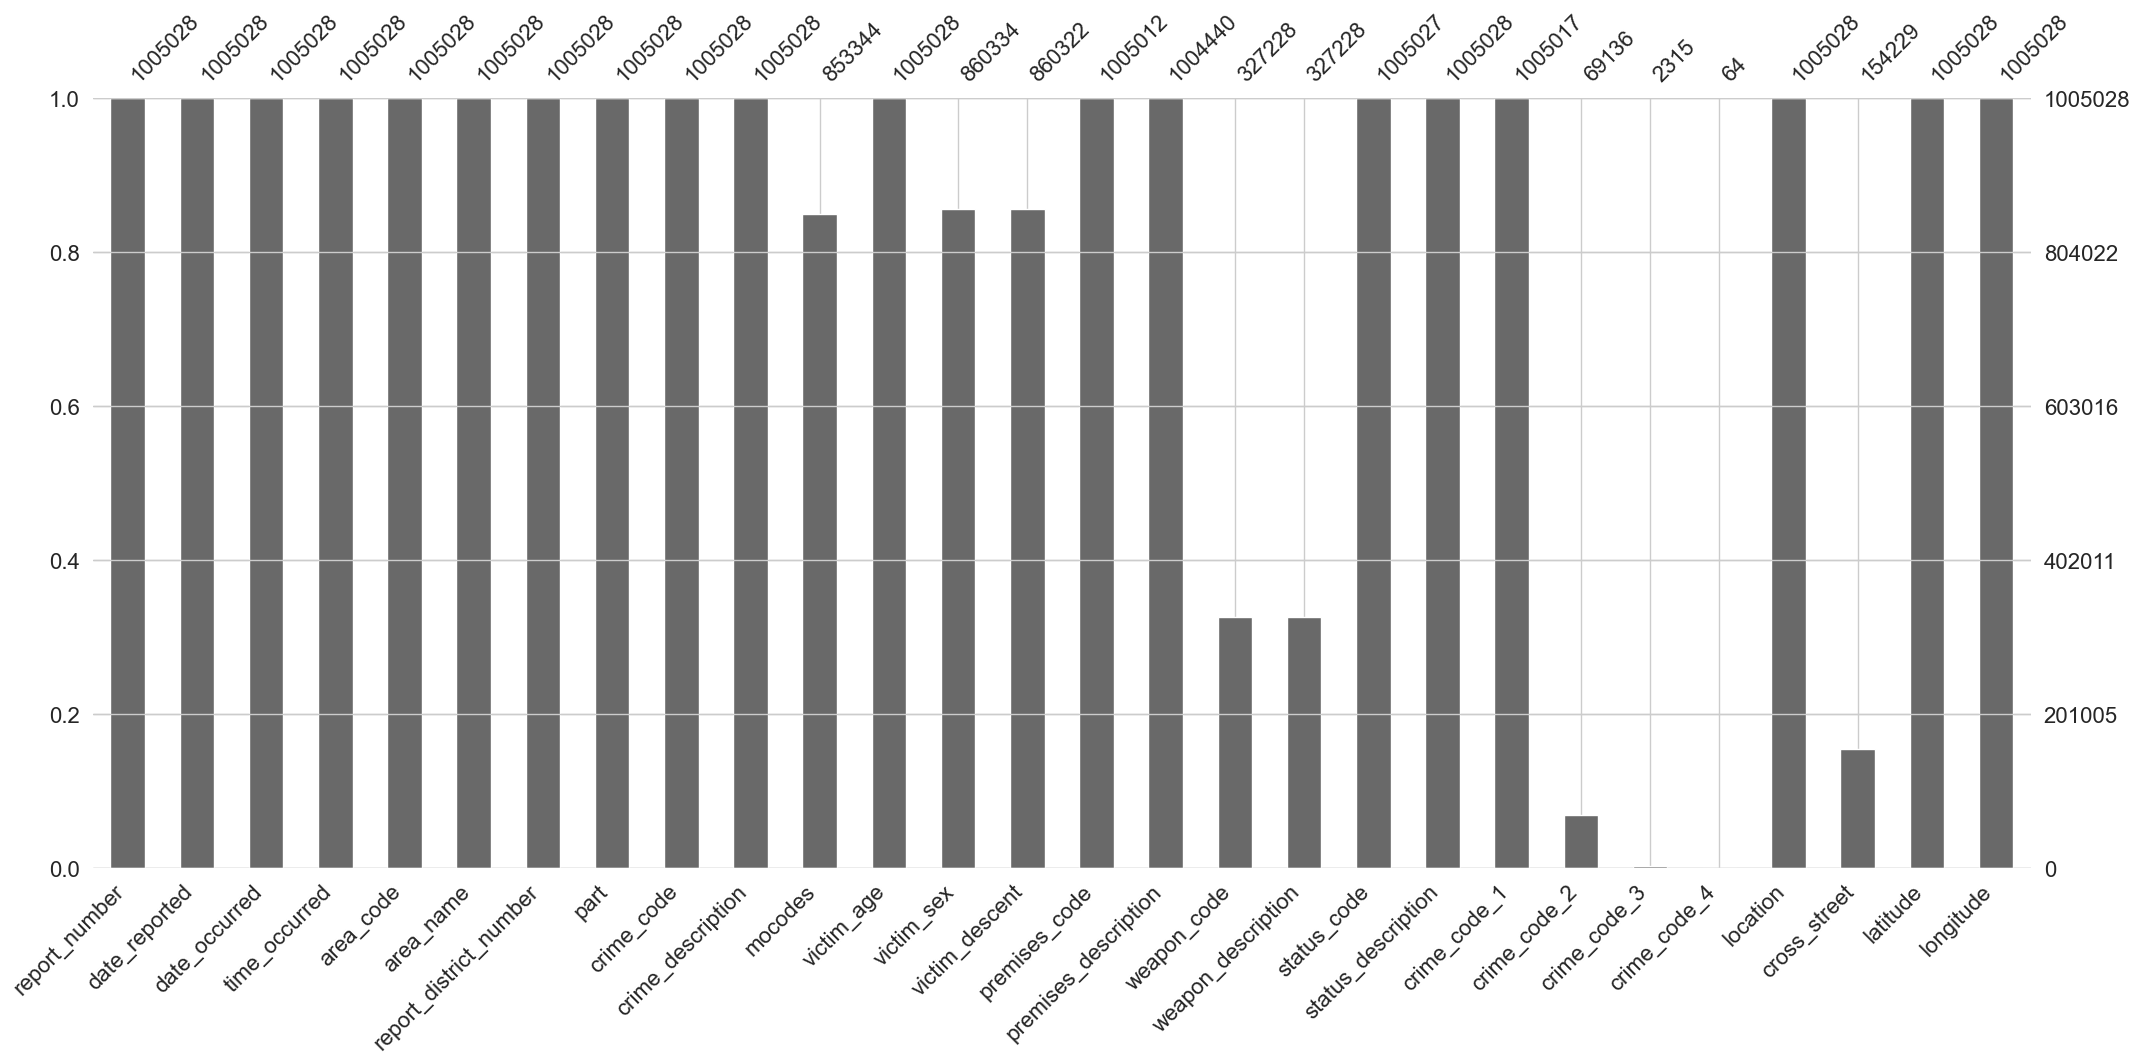

In [11]:
msno.bar(df);

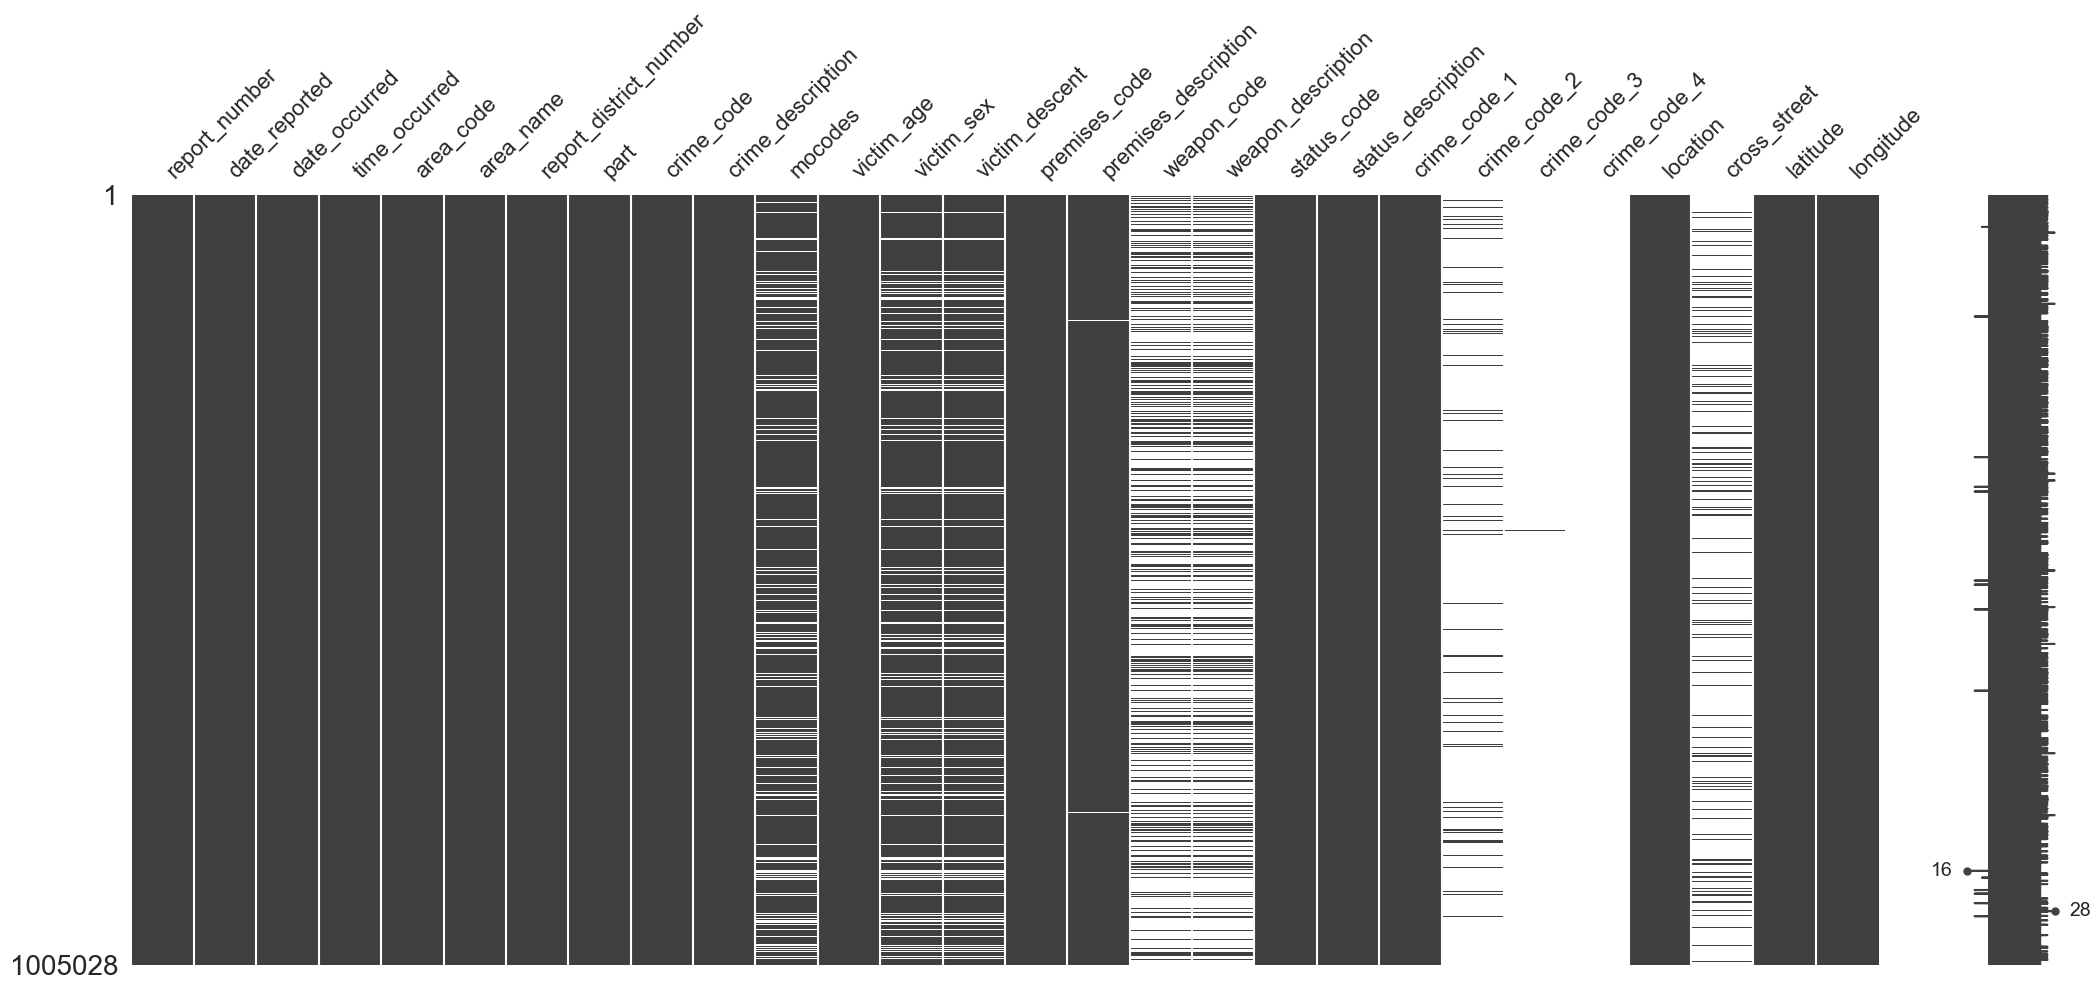

In [12]:
msno.matrix(df);

> The interesting to notice in the above matrix is that alot of the instances of missing values in victim_sex, victim_descent and mocodes are same, also weapon_code and weapon_description also are same but it makes sense since weapon_description is directly dependent on weapon_code

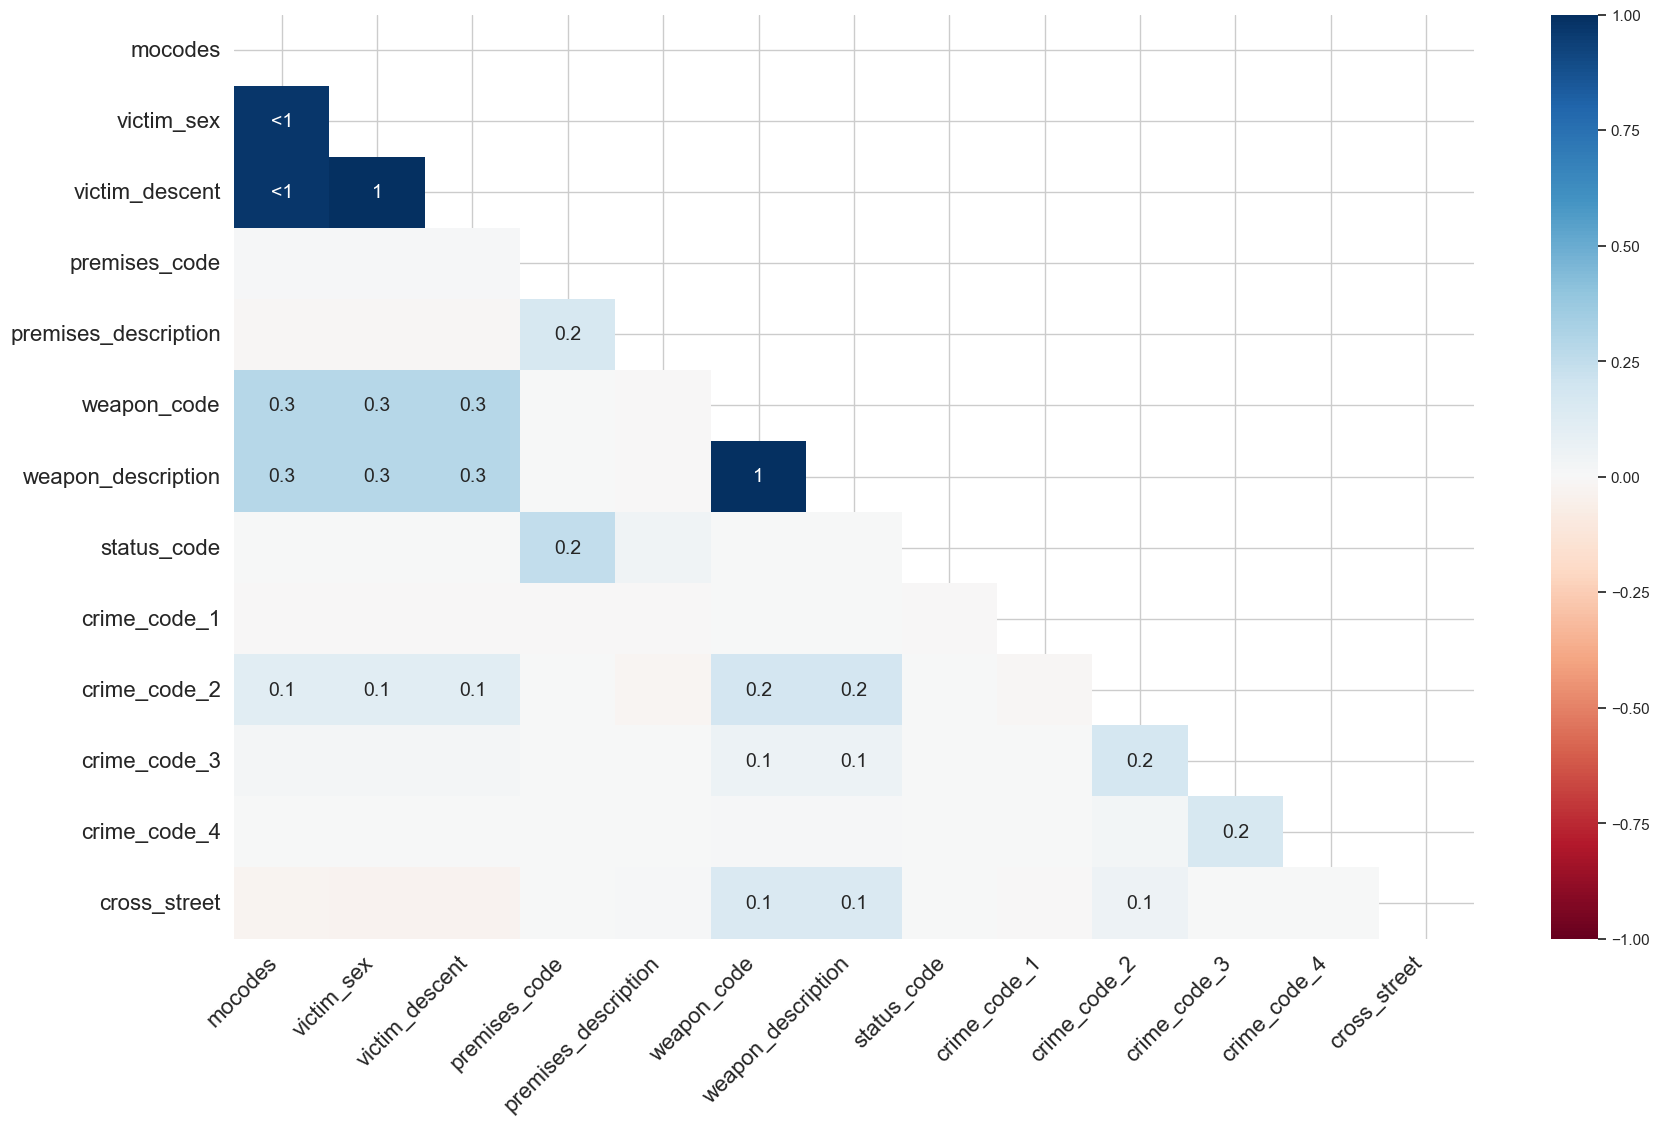

In [13]:
msno.heatmap(df);

The correlation has confirmed our observation that there is a very high null correlation between victim_sex and victim_descent with mocodes (<1) while victim_sex and victim_descent are completely correlated with each other (1). 

- "<1" mean there is very strong nullity correlation but there are still a few values that are random

- "1" there is a perfect correlation (Even though it is perfect, there could still be very few values that are random but they are very very less)

#### What is Nullity Correlation?

It means if one value is missing the probility of other value that has a nullity correlation with it has either higher or lower probability to be missing. (The missingness of one variable can somewhat be explained by the missingness of the other variable). This is not to be confused with normal correlation or with MAR, MCAR and MNAR concepts.

- 1: If one value is missing, the other is always missing.
- <1: If one value is missing, the other is *almost* always missing.
- 0: If one value is missing, we can not say anything about the other value.
- -<1: If one value is missing, the other value is *almost* never missing.
- -1: If one value is missing, the other value is never missing.

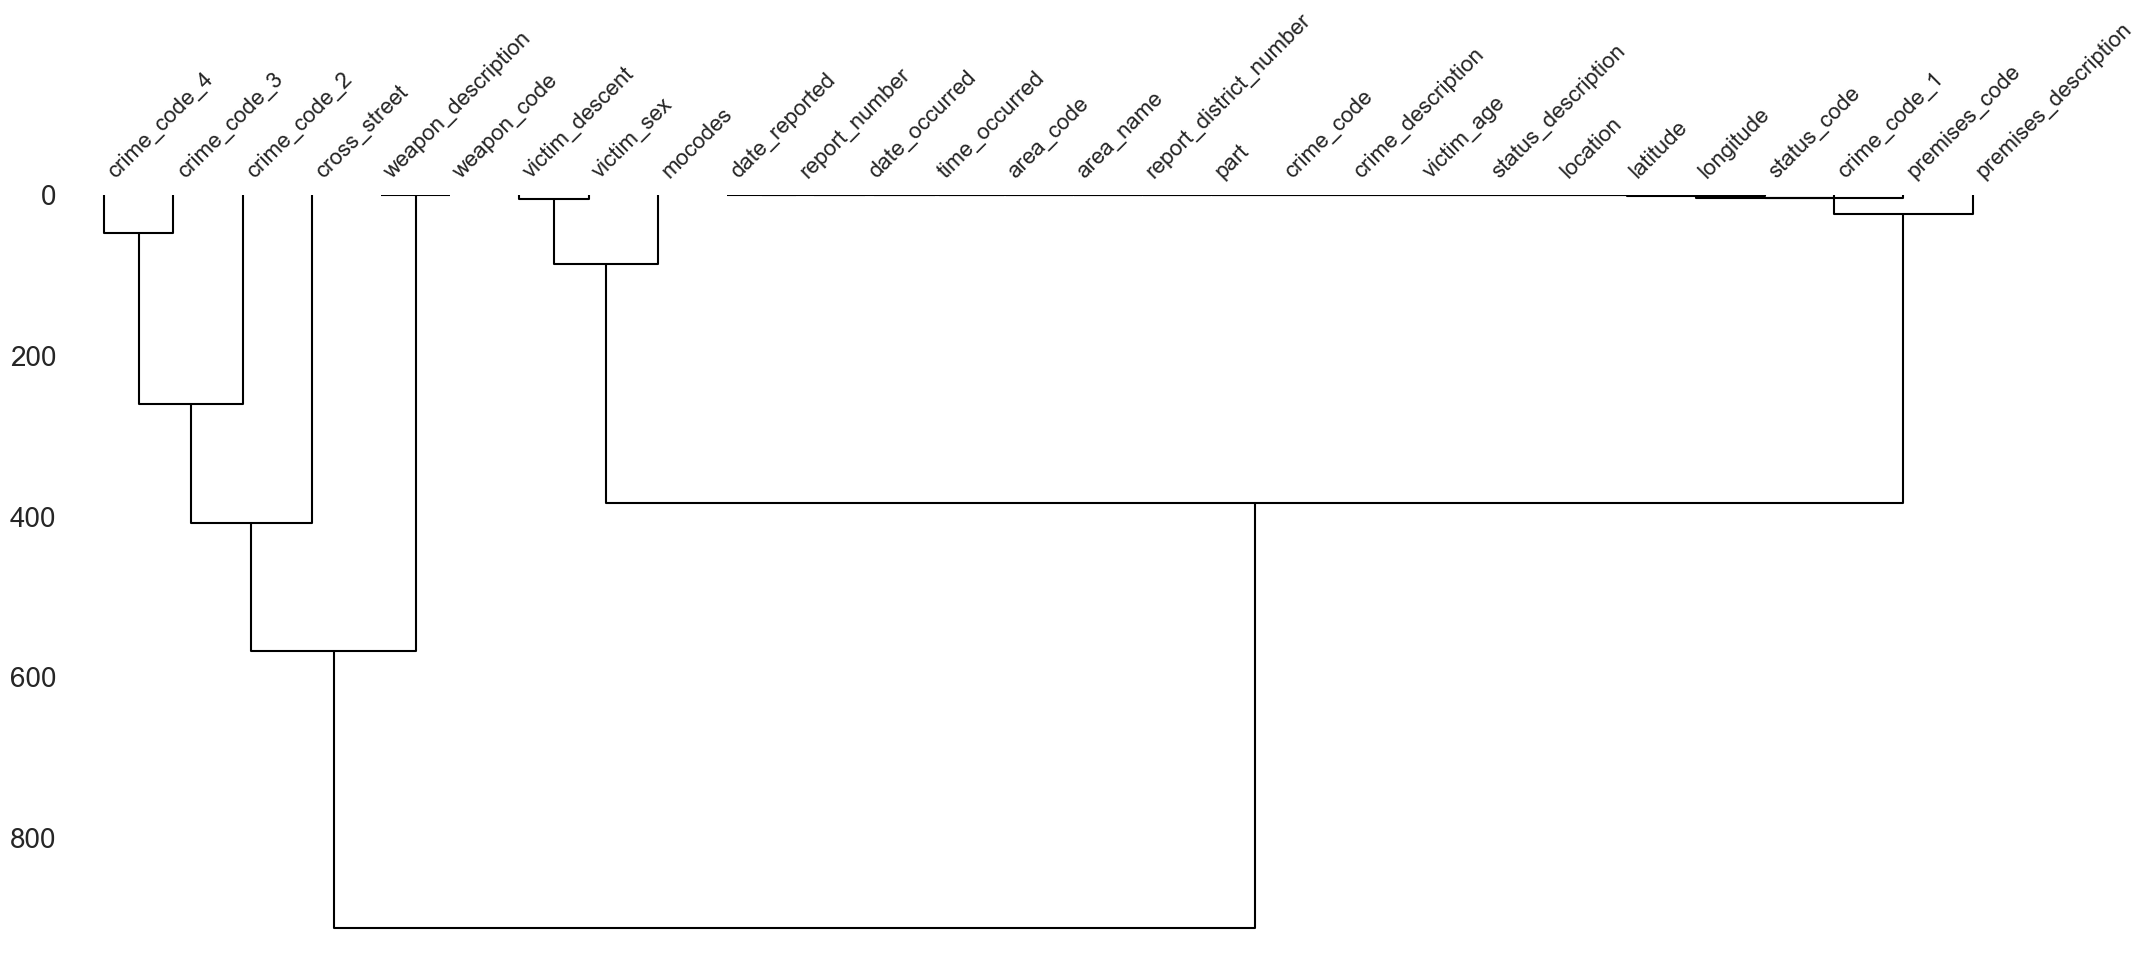

In [14]:
msno.dendrogram(df);

> We are also seeing the same results in this dendrogram, weapon_code and weapon_description converge very very quickly, followed by the convergence of victim_descent and victim_victim_sex, then their cluster converge with mocodes. So we have the following clear cluster for NaN values:

    - victim_sex, victim_descent, mocodes

In [15]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,report_number,817,252104053,1005028,0,0.0%,int64
2,date_reported,nan,nan,1865,0,0.0%,object
3,date_occurred,nan,nan,1859,0,0.0%,object
4,time_occurred,1,2359,1439,0,0.0%,int64
5,area_code,1,21,21,0,0.0%,int64
6,area_name,nan,nan,21,0,0.0%,object
7,report_district_number,101,2199,1210,0,0.0%,int64
8,part,1,2,2,0,0.0%,int64
9,crime_code,110,956,140,0,0.0%,int64


#### date_reported

- convert the column dtype from object to datatime, but the string need to parsed in a specific format so pandas to_datetime method can identify the correct format.

The format we have is "03/01/2020 12:00:00 AM", so we need to tell pandas how to parse (interpret) this string (what is day and what is month)

> Note: Please note that in USA the date format is MM/DD/YYYY while in Europe it is DD/MM/YYYY, so first always make sure what date format is being currently used. One easy way is to look at some date samples and see at which position the value more than 12 comes, and that would be the month. Pandas default date format is YYYY-MM-DD.

- 03 -> %m

- 01 -> %d

- 2020 -> %Y

- 12 -> %I (for 12 hour clock) 

- 00 -> %M

- 00 -> %S

- AM -> %p

>> So '03/01/2020 12:00:00 AM' should parse as '%m/%d/%Y %I:%M:%S %p'

> See the documentation for details [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

> Note: In usual dtypes conversion, we usually use `astype()` method but for date parsing we use `to_datetime()` method.

> Once we have the `datetime64[ns]` datatype, then we are good to go.


In [16]:
df.date_reported[0]

'03/01/2020 12:00:00 AM'

In [17]:
df.date_reported = pd.to_datetime(df.date_reported, format='%m/%d/%Y %I:%M:%S %p')
print(df.date_reported.dtype)
df.date_reported.head(3)

datetime64[ns]


0   2020-03-01
1   2020-02-09
2   2020-11-11
Name: date_reported, dtype: datetime64[ns]

> Plot a graph to see if our dates are parsed correctly

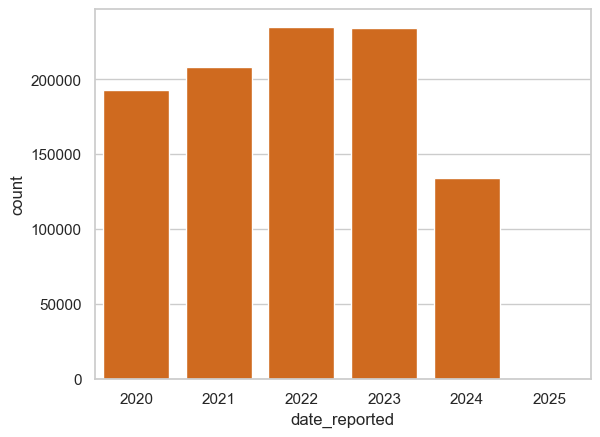

In [18]:
sns.countplot(x=df.date_reported.dt.year);

> We can notice that we have the highest number of records from 2022, does that mean the number of crimes reported were the highest in 2022 or the data were missing in other years?

#### date_occurred & time_occurred => datetime_occurred

> I would prefer to combine both the `date_occurred` and `time_occurred` columns because pandas datetime object expects both date and time and when both of them combined we will be able to use the pandas time series analysis.

> The date format here is the same, the time format is a little tricky, because it is just an int number representing time in 24h, but we can not directly parse it into time because to do so it has to be in exactly same format, now since it is an integer 00:10 is being shown as only 10, so what we need to do is to add padding of 4 after converting to str, so we will have the time in the same format from 0000 to 2359.

- 23 -> %H

- 59 -> %M

> so 2359 will be parsed as %H%M

In [19]:
df.loc[df.time_occurred.astype(str).str.zfill(4).isin(['0010'])].head(1)

,report_number,date_reported,date_occurred,time_occurred,area_code,area_name,report_district_number,part,crime_code,crime_description,mocodes,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,crime_code_1,crime_code_2,crime_code_3,crime_code_4,location,cross_street,latitude,longitude
509,200410168,2020-06-25,06/25/2020 12:00:00 AM,10,4,Hollenbeck,473,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1300,32,F,H,101.0,STREET,NaN,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,SOTO ST,INEZ ST,34.0365,-118.2144


> Here we see that the time is saved as int 10 when it should be 0010

In [20]:
df.date_occurred = pd.to_datetime(df.date_occurred, format='%m/%d/%Y %I:%M:%S %p')
df.time_occurred = pd.to_datetime(
    df.time_occurred.astype(str).str.zfill(4),
    format='%H%M'
)

In [21]:
df.date_occurred[0], df.time_occurred[0]

(Timestamp('2020-03-01 00:00:00'), Timestamp('1900-01-01 21:30:00'))

> Now we have both `date_occurred` and `time_occurred` as the datetime object, but we know that one only has date and the other only has time, by default pandas set the time to 00:00:00 when only the date was parsed, and the date to be 1900-01-01 when only the time was parsed (like in our case), so in order to combine them we first need to take the normalized date (our date is already normalized but just in case if there were any mistakes (normalized mean the time to be 00:00:00)) and add the time using the `to_timedelta()` method, we need to take hours and minutes separately by giving the unit argument and then add this time to date.

In [22]:
df['datetime_occurred'] = (
    df.date_occurred.dt.normalize() +
    pd.to_timedelta(df.time_occurred.dt.hour, unit='h') +
    pd.to_timedelta(df.time_occurred.dt.minute, unit='m')
)
df.datetime_occurred.head(1)

0   2020-03-01 21:30:00
Name: datetime_occurred, dtype: datetime64[ns]

> I don't think we would be needing `date_occurred` and `time_occurred` columns separtely now once we have `datetime_occurred`, so better to drop them.

In [23]:
df = df.drop(columns=['date_occurred', 'time_occurred'])

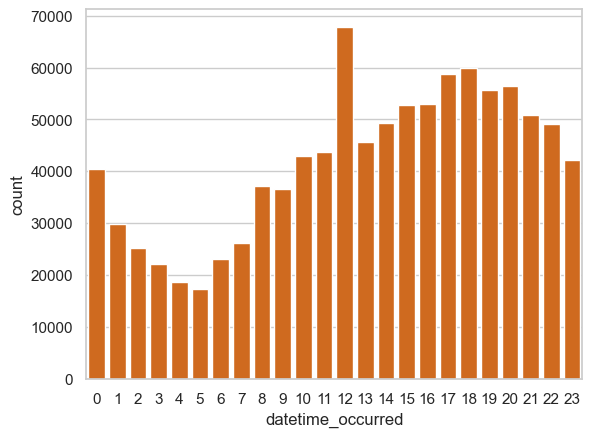

In [24]:
sns.countplot(x=df.datetime_occurred.dt.hour);

> Fun fact: This is a typical "hour of the day" graph that follows a negative sinusoidal pattern, it is usually seen when comparing the "activities" vs "hours" for example traffic, rush in a public place, etc. It also has to do with Energy Rhythms in a typical day.

> In our case we have anomoly at 12 where we see a strange peek that does not happen in usually hour of the day vs activities graph, it could be specific to the crime activities like unlike other activities in the afternoon happens the highest number of crime activities. But a sudden peak or change could also mean that the data is not correct (for example imputed to 12 o clock)

> Lets see more smooth graph by adding the minutes as well to see if this peak make sense...

In [25]:
df['time_occurred_float'] = df.datetime_occurred.dt.hour + df.datetime_occurred.dt.minute / 60
df.time_occurred_float.head(1)

0    21.5
Name: time_occurred_float, dtype: float64

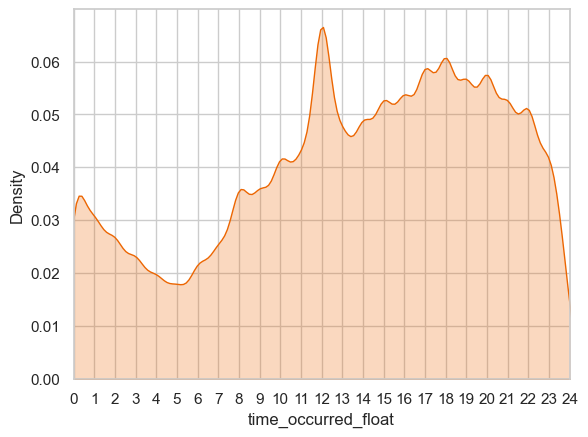

In [26]:
sns.kdeplot(data=df, x="time_occurred_float", fill=True)
plt.xlim(0, 24)
plt.xticks(range(0, 25))
plt.show()

#### area_code

In [27]:
df.area_code.sample(10)

784693    14
149293    16
451927    10
31570     10
875433    19
128679    14
541905    17
749577    20
925249     7
715612    20
Name: area_code, dtype: int64

> Since `area_code` is categorical column saved as an integer and also we saw above there are only 21 different values (categories) in this column, it makes sense to convert this column into category type. Also I am converting the data first from int64 to uint8 because the range as we saw above is from 1 to 21, so it should fit into uint8 (2^8=256 numbers from 0 to 255) which takes "theoretically" 8 times less space in memory as comapared to int64. But since we are then converting to category type anyways, it actually does not make alot of difference in memory. The memory usage in order of largest to smallest look like this:

>> int64 -> category(int64) -> category(uint8) -> uint8

> With the last 3 almost have the same memory, but if we wanted to optimize it for the least possible memory, uint8 would be the winner, but since it is a categorical variable, our best option is category(uint8).

In [28]:
print('int64:', df.area_code.astype('int64').memory_usage(index=False) / 1024**2)
print('uint8:', df.area_code.astype('uint8').memory_usage(index=False) / 1024**2)
print('category(int64):', df.area_code.astype('int64').astype('category').memory_usage(index=False) / 1024**2)
print('category(uint8):', df.area_code.astype('uint8').astype('category').memory_usage(index=False) / 1024**2)

int64: 7.667755126953125
uint8: 0.9584693908691406
category(int64): 0.9591598510742188
category(uint8): 0.958806037902832


In [29]:
df.area_code = df.area_code.astype('uint8').astype('category')

In [30]:
df.area_code.head(1)

0    7
Name: area_code, dtype: category
Categories (21, uint8): [1, 2, 3, 4, ..., 18, 19, 20, 21]

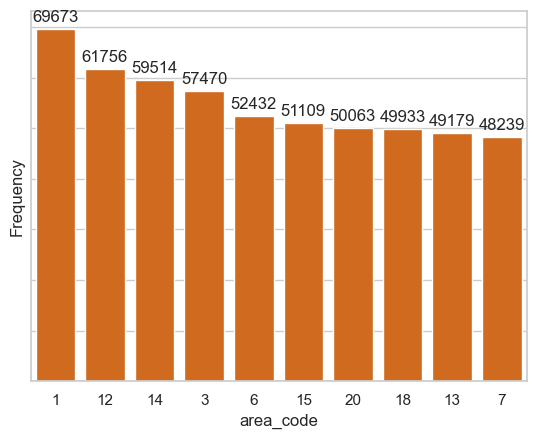

In [31]:
plot_top_categories(df.area_code, 10)

#### report_district_number

> Similarly here as well, it is a categorical type saved as int, but since the range is now from 101 to 2199, we convert it first to 'uint16' and then to 'category'

In [32]:
df.report_district_number = df.report_district_number.astype('uint16').astype('category')
df.report_district_number.head(5)

0    784
1    182
2    356
3    964
4    413
Name: report_district_number, dtype: category
Categories (1210, uint16): [101, 105, 109, 111, ..., 2196, 2197, 2198, 2199]

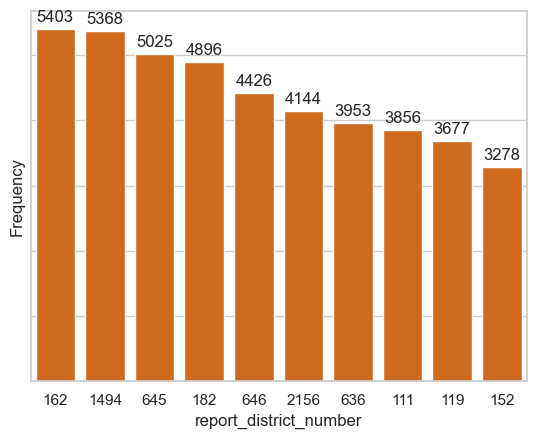

In [33]:
plot_top_categories(df.report_district_number)

#### part

In [34]:
df.part.head(3)

0    1
1    1
2    1
Name: part, dtype: int64

>Now converting this column to category since the value mapping is only 2 values, one can also think of keeping this column as bool with a name like `is_part_1` and then map 1 and 2 to True and False respectively. But it won't help us alot in terms of memory_usage, since Pandas use 1 byte instead of theoretical 1 bit for bool dtype, so it is going to take up the same memory as category(str) with 2 values with a little overhead in the category dtype. So in Pandas it is almost always not helpful to prefer bool over category(str) dtype and compromise on readability, except ofcourse the operations become much easier with bool type 

>For example the following command is enough to convert the `part` column to bool type:

```python
df.part = df.part == 1 # returns bool
```

>While for doing the exact same thing but with non-bool type would require one of the following command:
```python
df.part = df.part.map({1: "Part 1", 2: "Part 2"}).astype('category') # returns category(str)
or
df.part = df.part.replace({1: "Part 1", 2: "Part 2"}).astype('category')
```


In [35]:
df.part = df.part.astype('category')

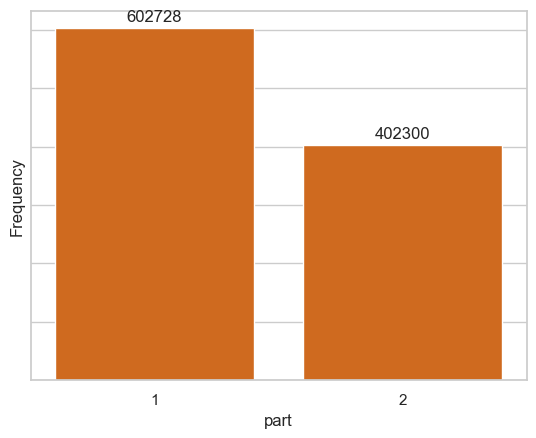

In [36]:
plot_top_categories(df.part);

#### crime_code, crime_code_1, crime_code_2, crime_code_3, crime_code_4

>From the EDA, we can see that crime_code is repeated in one of the crime_code 1-4, so 
if we remove crime_code and explode the crime_code_1-4, we will get all the crime_codes together,
also there are missing values in crime_code_1-4, there is no instance where all of them are missing
so we have a complete data of crime_code.

>Below I am confirming if there is ANY instance where crime code is NOT being repeated in either of the crime_codes_1-3, and it IS the case since no values are returned.

In [37]:
df[(df.crime_code != df.crime_code_1) & (df.crime_code != df.crime_code_2) & (df.crime_code != df.crime_code_3)].shape

(0, 28)

>**crime_codes column is exploded later in the notebook**

#### mocodes

> Again `mocodes` column need to be exploded, done after cleaning other columns

#### victim_age

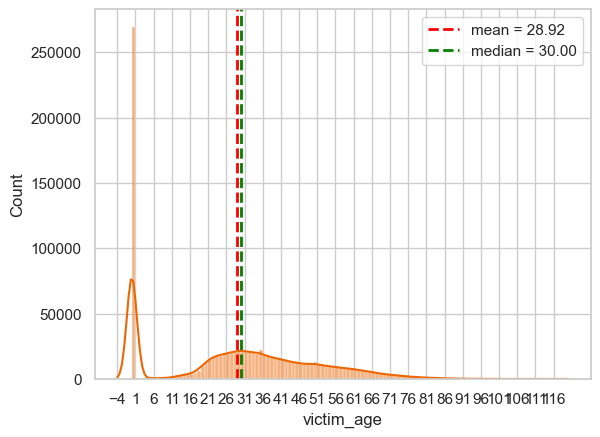

In [38]:
plot_histogram(df.victim_age)

In [39]:
df.victim_age.skew(), df.victim_age.kurt()

(np.float64(0.1625431035261872), np.float64(-0.7925607277950424))

> The distribution looks normally distributed, except there is a very large occurrence of the age 0, which should mean that it actually represents NaN values, also there are some obviously wrong values that are negative.

> So the first step would be to convert wrong values to NaN

In [40]:
df.loc[df.victim_age <= 0, 'victim_age'] = np.nan

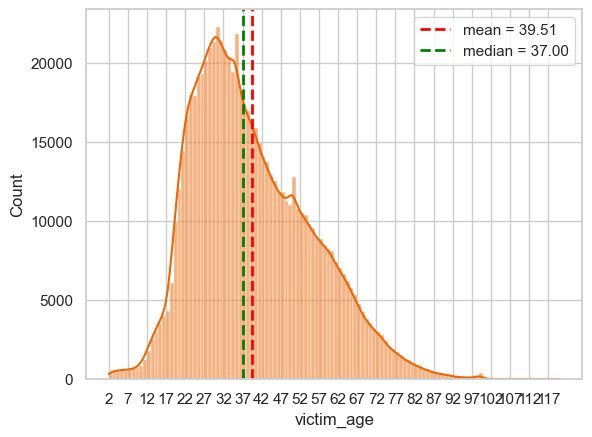

In [41]:
plot_histogram(df.victim_age)

> Now the graph looks completely what you would expect from the age distribution graph

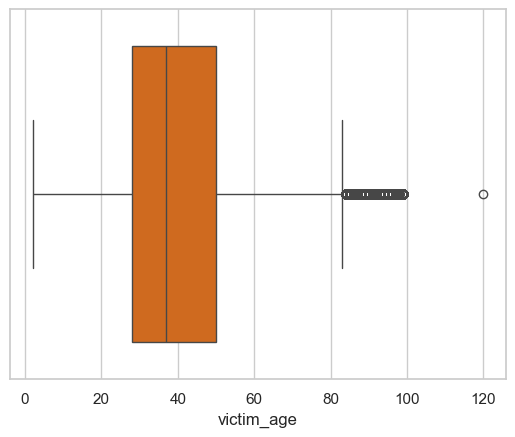

In [42]:
sns.boxplot(x=df.victim_age);

> There are some outliers, but clearly they are just older people, so they don't really affect the distribution and we have very small positive skewness anyways, so these outliers can be ignored.

In [43]:
df.loc[show_outliers(df.victim_age).index].head(3)

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_code,crime_description,mocodes,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,crime_code_1,crime_code_2,crime_code_3,crime_code_4,location,cross_street,latitude,longitude,datetime_occurred,time_occurred_float
212,201221820,2020-10-02,12,77th Street,1273,2,624,BATTERY - SIMPLE ASSAULT,1202 1701 2021 0913 0562 0444 0443,85.0,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624.0,NaN,NaN,NaN,8800 S HALLDALE AV,NaN,33.9574,-118.3025,2020-10-02 06:00:00,6.0
350,200717236,2020-12-18,7,Wilshire,752,1,320,"BURGLARY, ATTEMPTED",1822 1602 0397 0329,84.0,F,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,320.0,NaN,NaN,NaN,1200 ALVIRA ST,NaN,34.0532,-118.3729,2020-12-18 11:00:00,11.0
404,200314030,2020-07-11,3,Southwest,363,2,354,THEFT OF IDENTITY,1202 0121 1822 0100,90.0,F,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,3900 MARLTON AV,NaN,34.0133,-118.3370,2020-07-11 15:00:00,15.0


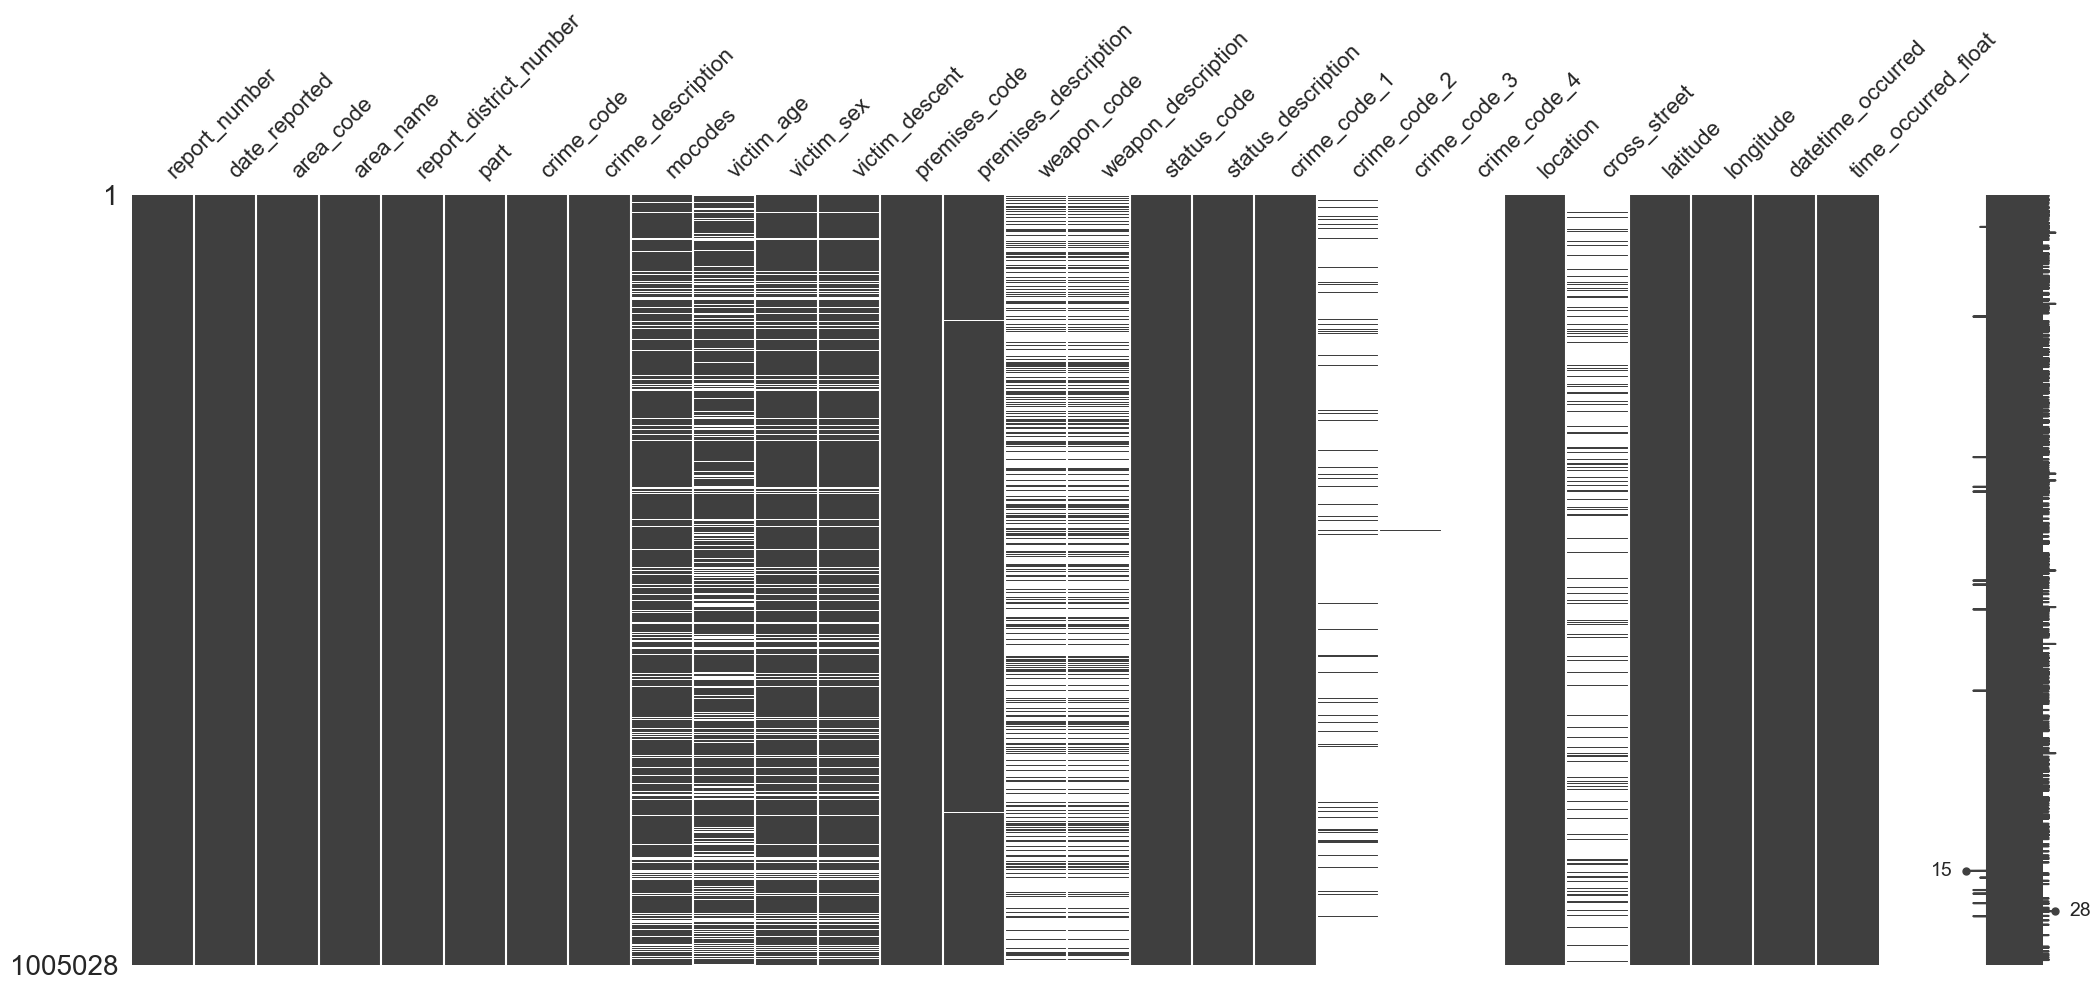

In [44]:
msno.matrix(df);

> Now we can see the dendrogram with age missing values, which we previously had overlooked.

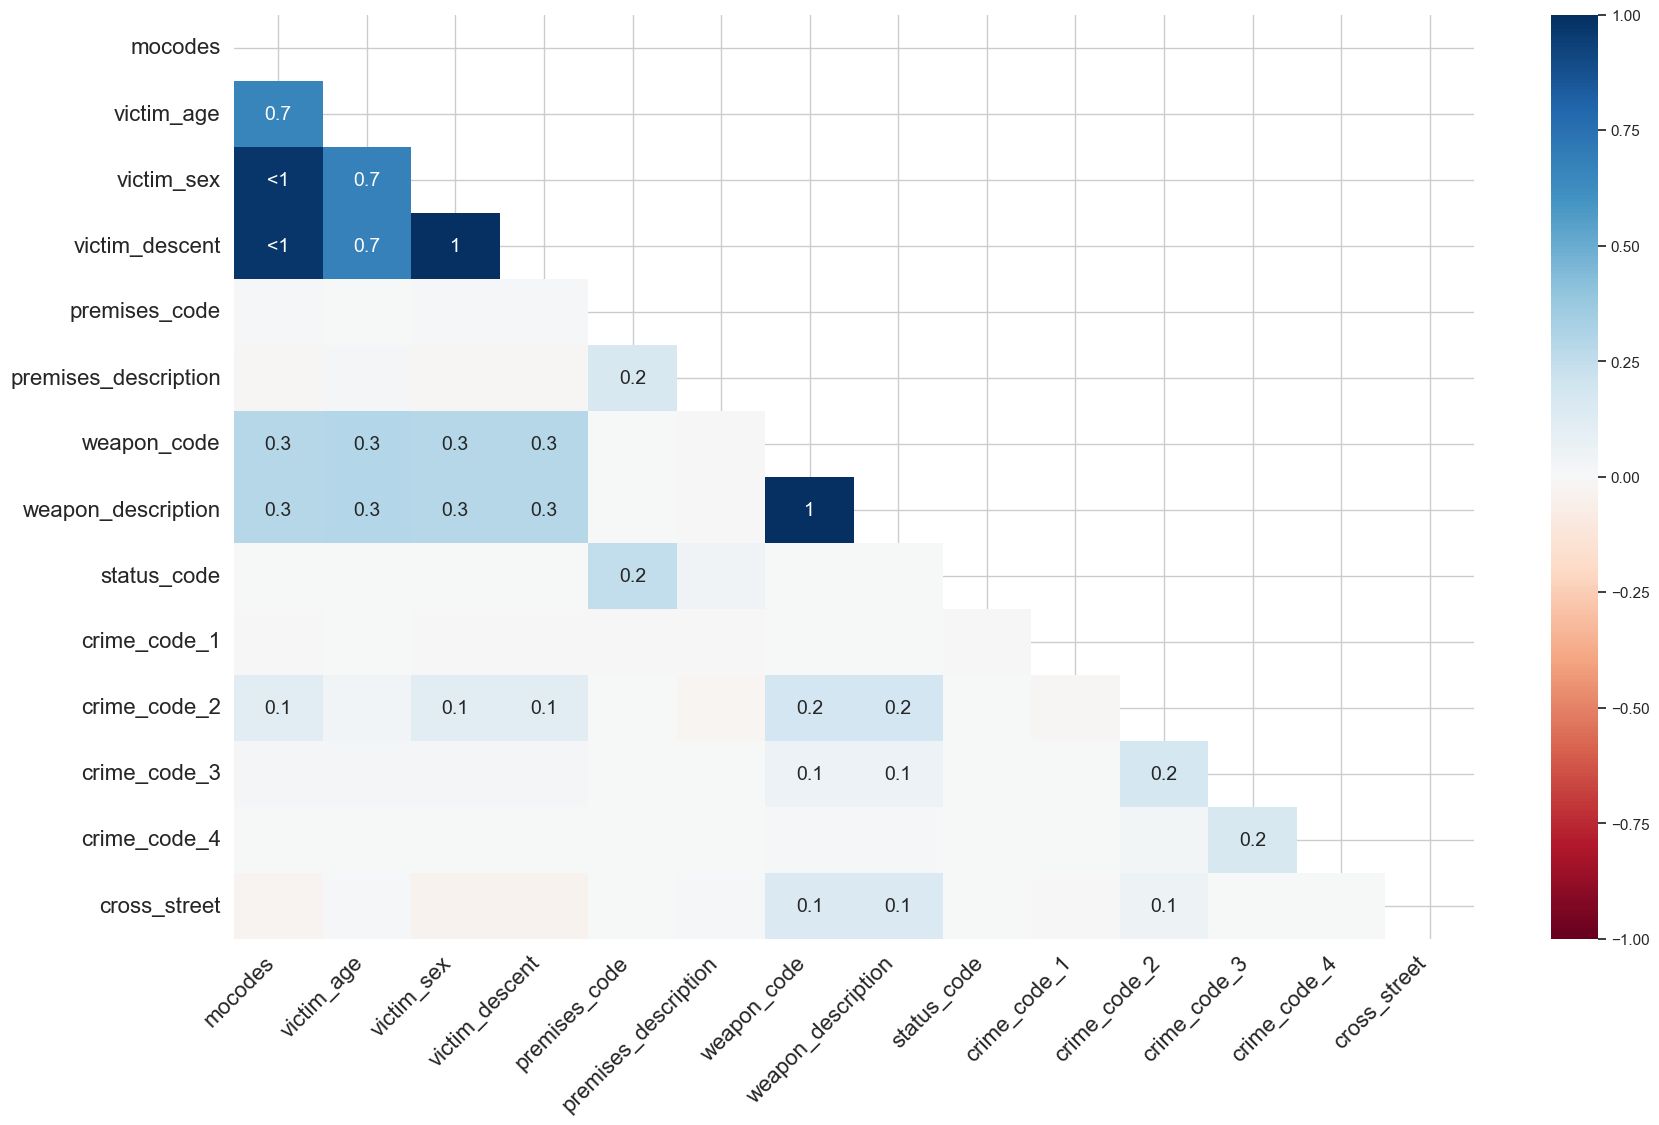

In [45]:
msno.heatmap(df);

> Age has a high nullity correlation with victim_sex, victim_descent and mocodes

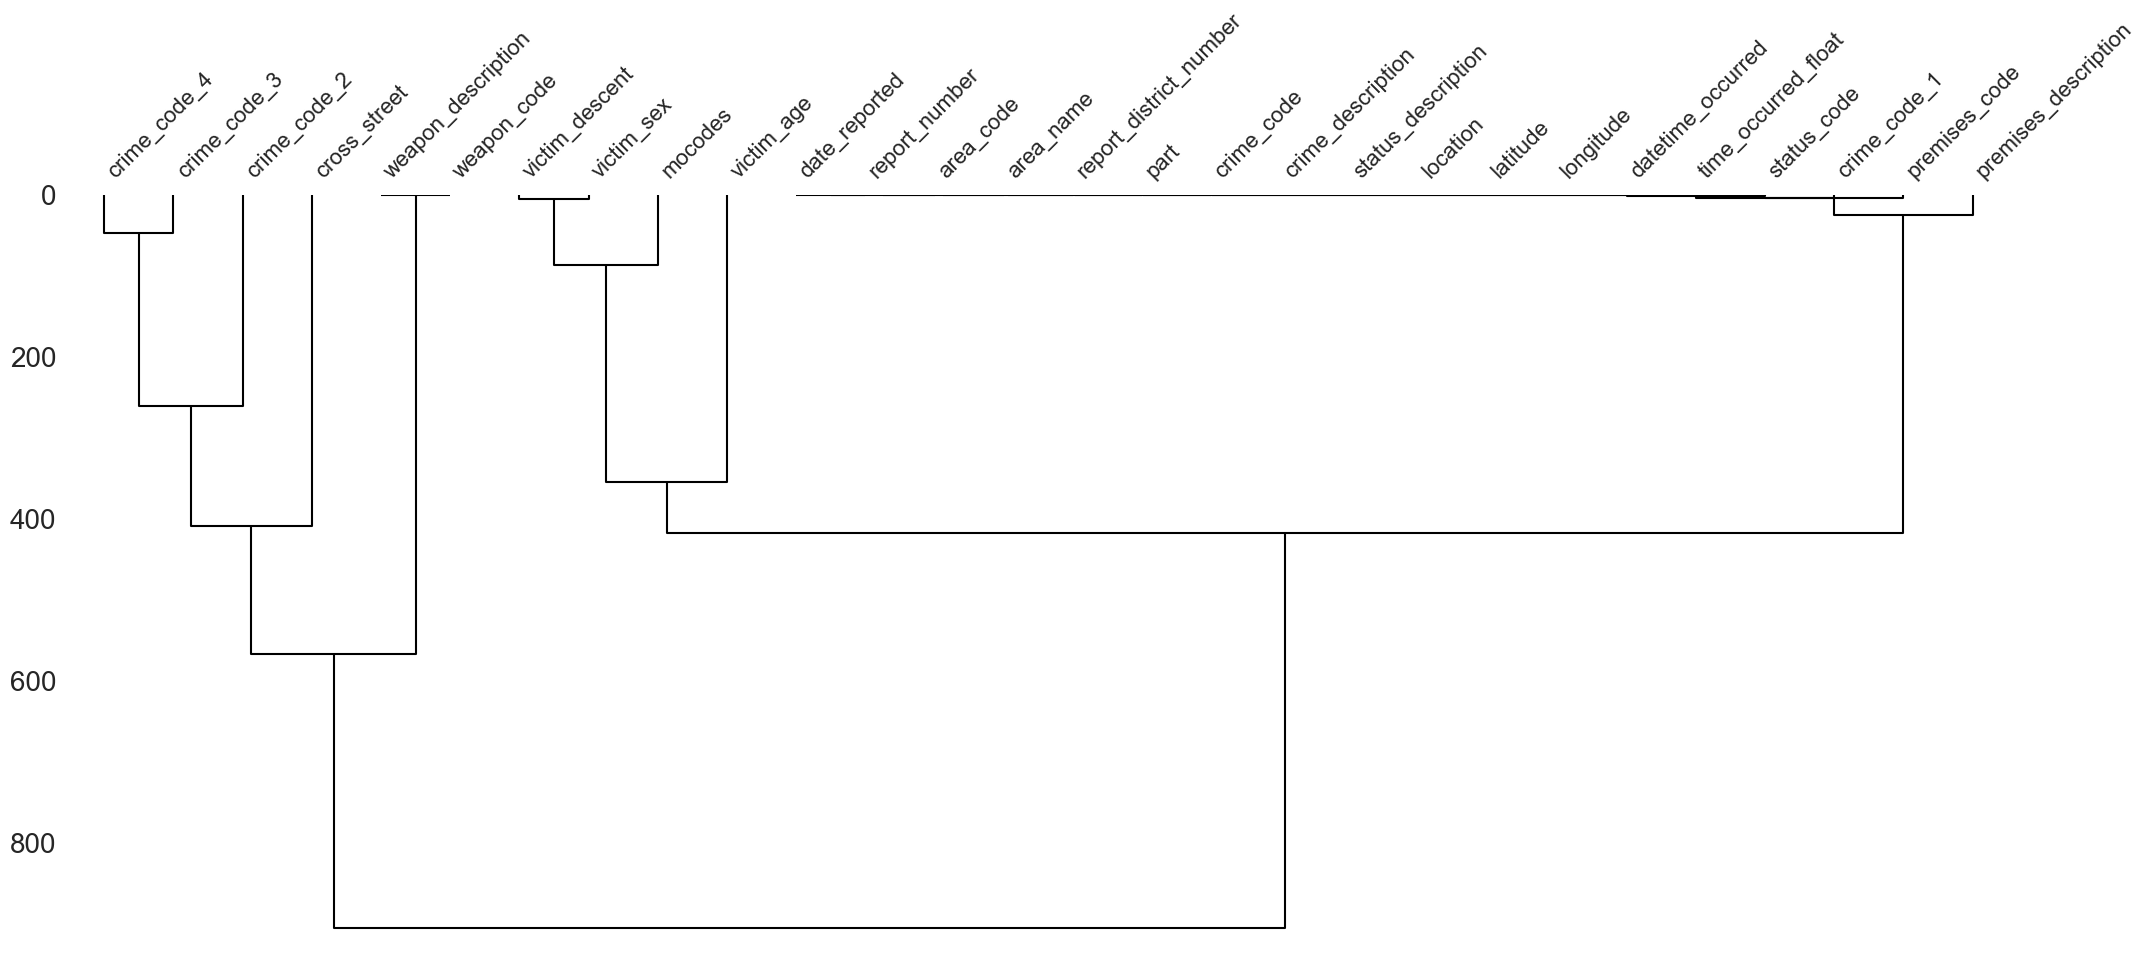

In [46]:
msno.dendrogram(df);

Now we have the following cluster as opposed to before:

1. victim_sex, victim_descent, mocodes, victim_age

> NaN values for all the variables in a cluster must be handled together.

#### Cluster:
- victim_age
- victim_sex
- victim_descent
- mocodes



> I want to see if the missing values of Age has different distributions for other variables as compared to the distributions of those variables when the age is not missing, if that is the case, then it would be MAR (Missing at Random) case. Otherwise it would be MCAR case.

What are MCAR, MAR and MNAR cases?
- MNAR: If the distribution of a variable when the values are missing is different than the distribution when the values are not missing. This case is most tricky and can only be resolved by domain-knowledge, asking SME or getting outside data.

- MAR/MCAR: If the data is not MNAR which is mostly the case unless we have a strong reason to believe otherwise, we can almost always assume that the distribution of missing values is approximately similar to the distribution of non missing values. In other words the missing value is just a sample from the population (non-missing values). Now it could either be MAR or MCAR. If the correlated variables also have the same distribution when the values are missing as when the values are not missing, then it is the easiest case i.e. MCAR, otherwise it is MAR.
To solve MCAR.

In case of MCAR, the following techniques could be used:
Note: These techniques can only be used when the share of missing values is small, the bigger the share of missing values is, the higher the chance of completely changing the description of the data.

- Deleting the rows: Only if it's not alot of data and data completeness is not very important and we are not losing some important (very useful) information
    - Advantages: 
        - Easy to do
    - Disadvantages:
        - Losing data completeness
        - Sometimes losing some important (very useful) information
- MMM Imputation: Impute the NaN values with Mean, Median or Mode. If there is a correlation with other variables, it's better to take the grouped MMM values. Will be discussed further later on. Also which one to choose, mean, median or mode is also discussed further.
    - Advantages:
        - Easy to do
    - Disadvantages:
        - Extra focus on specific values, in case of categorical sometimes its even okay but in case of numerical variables, the high focus on a specific value make the representation unnatural. Even when using grouped mmm values, it could still be the case that there are some specific unusual peaks for specific values
        - Can add bias into the model
        - Can change the higher moments of the original distribution (std, skewness, kurtosis)
- Random Sample Imputation: Since in MCAR case, we already know that the the missing values is just a randomly taken sample from our population (non missing values), so we already know the exact distribution that this random sample (missing values) should follow, so we can assume the values that are following the distribution.
    - Advantages:
        - Do not change the moments of the original distribution
        - No high focus on specific values
    - Disadvantages:
        - Can add bias into the model

There are some other common techniques like interpolation, ffill, bfill for time-series or OOR-Value Imputation with Flag for ML but in this case they are not very relevant.

**Note: It is also very helpful to add a flag column whenever imputing a value to be able to differentiate the values that are original and are imputed. How to add a flag column is later on**

In case of MAR, the only method I can think of now is using a machine learning model, which we are avoiding in this project.

>Let's compare the distributions of some correlated variables to victim_age to see if they are same when victim_age is missing and not missing. In other words, let's check if victim_age is MCAR or MAR (we are already assuming that it is NOT MNAR since we have no reason to believe otherwise)

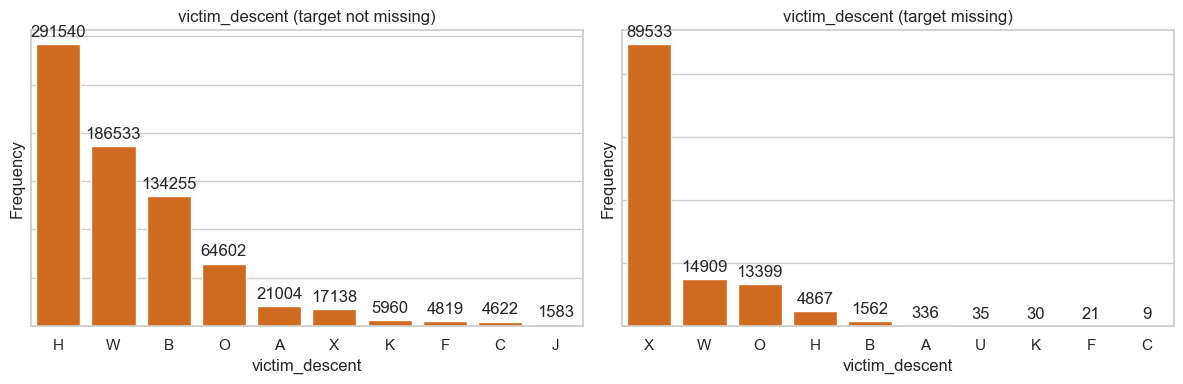

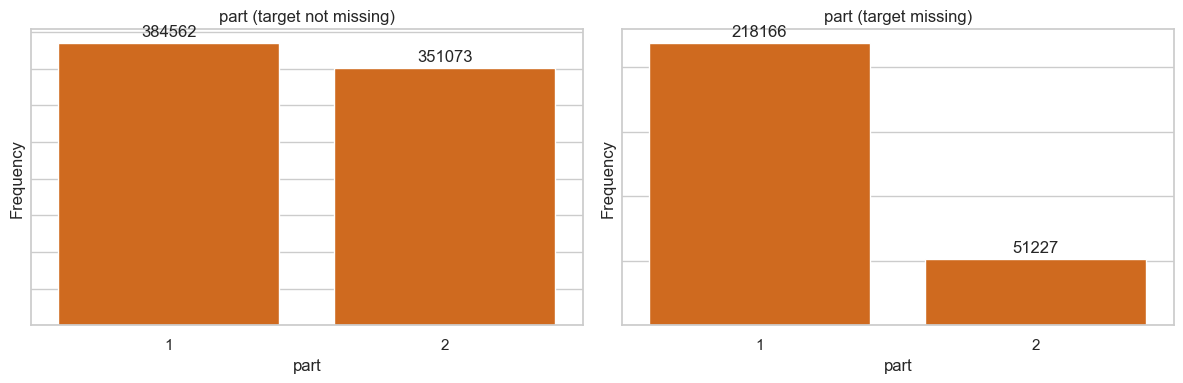

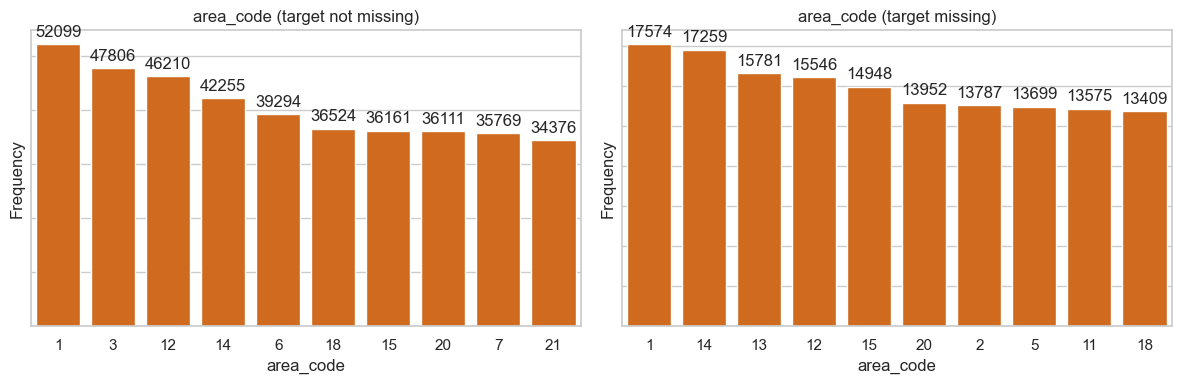

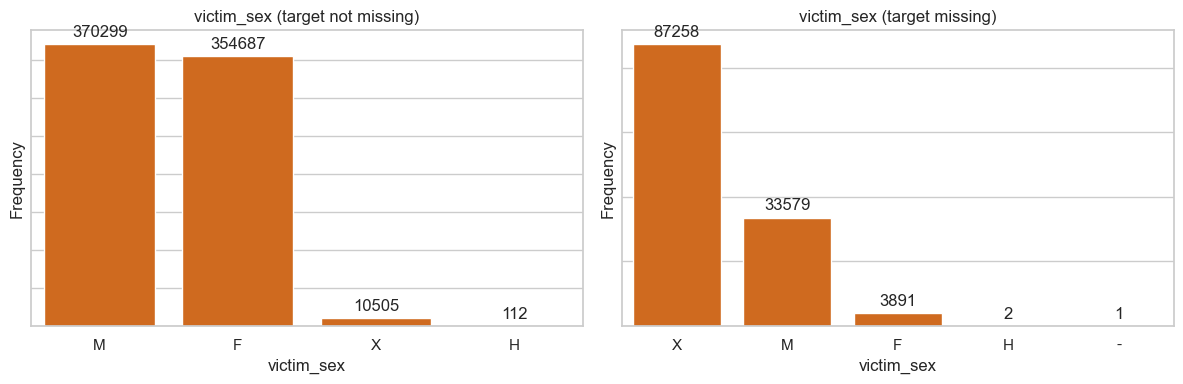

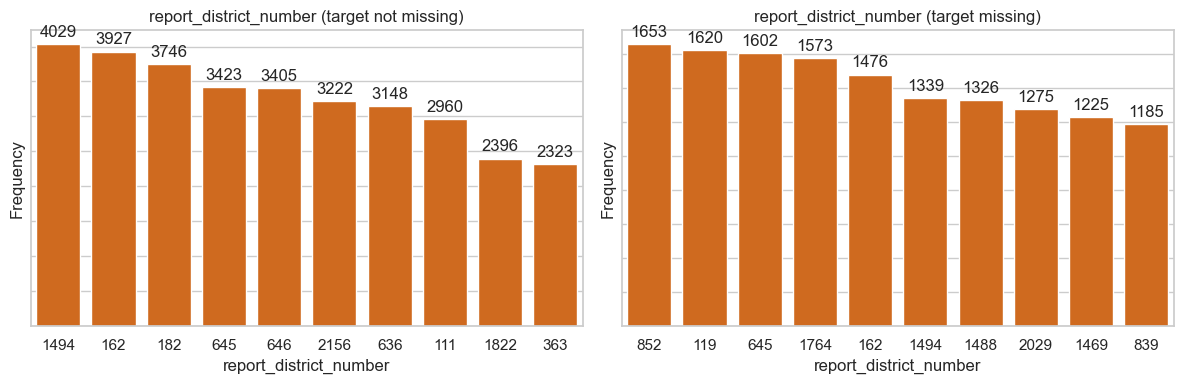

In [47]:
columns_to_filter = ['victim_age', 'victim_descent', 'part', 'area_code', 'victim_sex', 'report_district_number']

show_mar_relation(df[columns_to_filter], target_col='victim_age')
plt.show()

> Here we are already seeing that most of the distributions of the variables are different in each case, we can not say for sure if it is significant without a statistical test but it seems like it.

> Nonetheless we are going to ignore the fact that it could potentially be MAR case since due to time constraints we can not perform a statistical test to confirm and even if we are able to confirm it, we won't be able to use a machine learning model to impute the NaN values, so we are going to deal with these NaN values as if they were a MCAR case.

### victim_sex

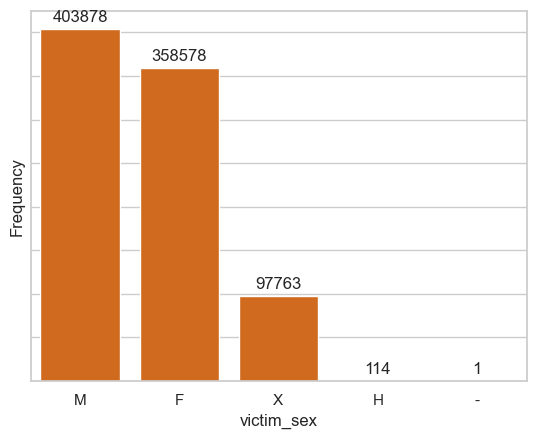

In [48]:
plot_top_categories(df.victim_sex)

> What does X mean? Could it mean NaN values? Yes because we also saw in the above diagram while comparing the missing vs non missing values for age, that when the age was missing, the frequency of X in victim_sex was also very high and we know from our dendropgram that victim_sex and victim_age has a high nullity correlation, so we can safely assume that this X mean NaN values. Also H anad - could also be NaN values since they are too few to spend time to think if they could mean something else.

> Replacing X, H and - with NaN

In [49]:
df.loc[df.victim_sex.isin(['X', '-', 'H']), 'victim_sex'] = np.nan
df.victim_sex.isna().mean()

np.float64(0.2413584497148338)

### victim_descent

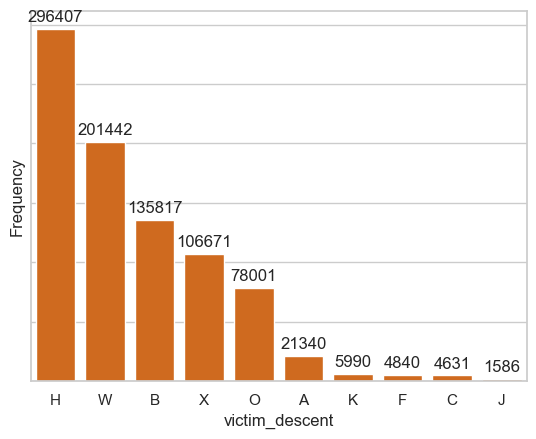

In [50]:
plot_top_categories(df.victim_descent);

In [51]:
df.victim_descent.unique()

array(['O', 'X', nan, 'W', 'H', 'B', 'A', 'K', 'C', 'F', 'Z', 'V', 'I',
       'P', 'J', 'G', 'U', 'D', 'S', 'L', '-'], dtype=object)

> Similarly here X and - can be assumed as NaN values

In [52]:
df.loc[df.victim_descent.isin(['X', '-']), 'victim_descent'] = np.nan
df.victim_age.isna().mean()

np.float64(0.2680452683905324)

### mocodes

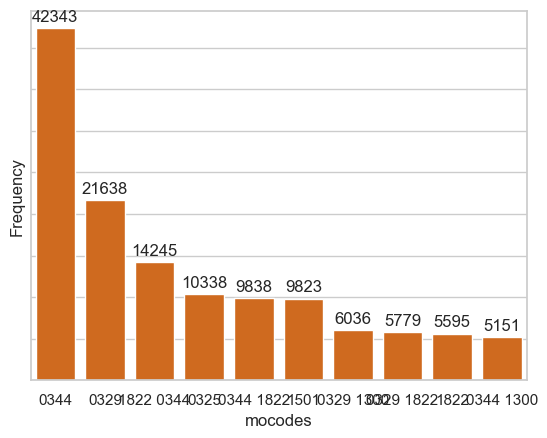

In [53]:
plot_top_categories(df.mocodes);

In [54]:
df.mocodes.value_counts()

mocodes
0344                                       42343
0329                                       21638
1822 0344                                  14245
0325                                       10338
0344 1822                                   9838
                                           ...  
0529 0323                                      1
0416 1259 2024 0419 0429 0913 1817 1251        1
1822 0311 0329 0327 1300                       1
0342 2024 0446 0913                            1
0529 0528 1251                                 1
Name: count, Length: 310837, dtype: int64

In [55]:
show_missing_values(df[['mocodes', 'victim_age', 'victim_sex', 'victim_descent']])

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,mocodes,nan,nan,310837,151684,15.093%,object
2,victim_age,2.0,120.0,99,269393,26.805%,float64
3,victim_sex,nan,nan,2,242572,24.136%,object
4,victim_descent,nan,nan,18,251379,25.012%,object


> It is very risky to impute the age value since there is a very big share of missing values...

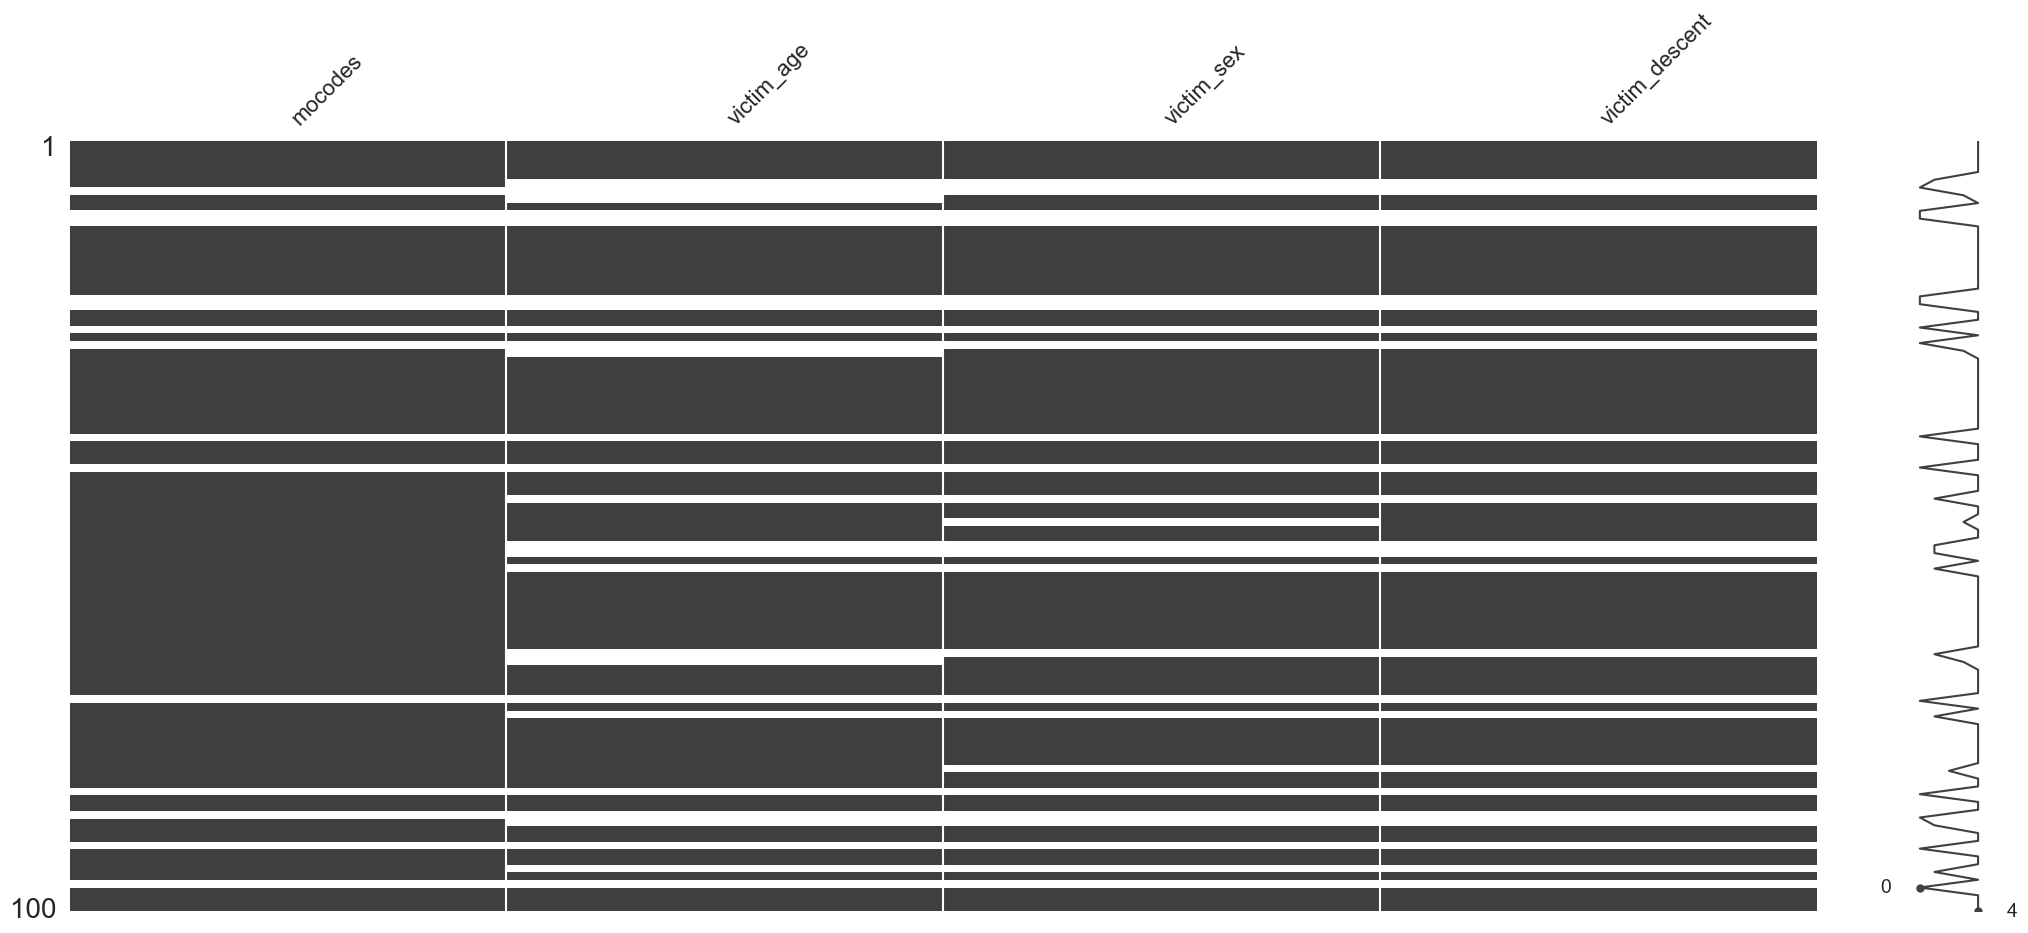

In [56]:
msno.matrix(df[['mocodes', 'victim_age', 'victim_sex', 'victim_descent']].sample(100));

> Here it can be noticed that whenever the mocode is missing, the other 3 variables are also missing, so maybe it is helpful to delete the NaN mocode which will drastically decrease the NaN values of other columns too especially victim_age so we will be able to safely impute them using an imputation technique.

In [57]:
show_missing_values(df[['mocodes', 'victim_age', 'victim_sex', 'victim_descent']].dropna(subset=['mocodes']))

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,mocodes,nan,nan,310837,0,0.0%,object
2,victim_age,2.0,120.0,99,123389,14.459%,float64
3,victim_sex,nan,nan,2,97224,11.393%,object
4,victim_descent,nan,nan,18,105829,12.402%,object


> Yes! It is actually true, if we delete the mocode NaN values, we will have alot smaller share of other variables that can be imputed. Let's do it.

In [58]:
df = df.dropna(subset=['mocodes'], ignore_index=True)
show_missing_values(df[['mocodes', 'victim_age', 'victim_sex', 'victim_descent']])

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,mocodes,nan,nan,310837,0,0.0%,object
2,victim_age,2.0,120.0,99,123389,14.459%,float64
3,victim_sex,nan,nan,2,97224,11.393%,object
4,victim_descent,nan,nan,18,105829,12.402%,object


> As I mentioned before, it is very helpful to add a flag before imputing the values, in case if we need to differentiate the imputed vs the original values.

In [59]:
df['is_victim_age_imputed'] = df.victim_age.isna()
df['is_victim_sex_imputed'] = df.victim_sex.isna()
df['is_victim_descent_imputed'] = df.victim_descent.isna()

> Let's do the random sample imputation on victim_age

In [60]:
df['victim_age_with_random_imputation'] = impute_random(df.victim_age, random_seed=RANDOM_SEED)
df.victim_age_with_random_imputation.isna().mean()

np.float64(0.0)

> Before doing the MMM imputation, we first have to decide with which M we want to impute a value

In [61]:
impute_mmm(df.victim_age)

,Value,Count,Percentage
Statistics,,,
Mean,39.501764,0,0.000000
Median,37.000000,17303,2.370420
Mode,30.000000,22135,3.032379
Mean without Outliers,39.206018,0,0.000000
Median without Outliers,36.000000,18073,2.490691
Mode without Outliers,30.000000,22135,3.050486


> From this comparision, I would go with Median, even though in Mean could also be a good choice since it is not really affected by outliers, but I still prefer Median since Mean is a decimal number which means it has to be round up and down which would further increase the imputation error, also Median already has a few occurrences showing that it is a very valid value and also closer to Mode, so overall Median seems like a good choice.

In [62]:
df.pivot_table(index=['victim_sex', 'part'], columns='victim_descent', values='victim_age', aggfunc='median', observed=True)

victim_descent      A     B     C     D     F     G     H     I     J     K  \
victim_sex part                                                               
F          1     39.0  35.0  30.0  33.0  35.0  32.5  34.0  31.0  39.0  36.0   
           2     38.0  35.0  34.0  33.0  40.0  32.0  34.0  35.0  45.5  41.0   
M          1     39.0  37.0  30.0  34.0  36.0  37.0  36.0  32.0  40.0  37.0   
           2     41.0  39.0  34.0  36.0  37.0  40.0  36.0  35.0  42.0  41.0   

victim_descent      L     O     P     S     U     V     W     Z  
victim_sex part                                                  
F          1     39.0  38.0  36.0  30.0  32.5  31.0  38.0  30.0  
           2     32.5  39.0  32.0  31.5  35.0  34.0  40.0  37.0  
M          1     30.0  39.0  37.0  40.0  34.0  32.0  40.0  32.0  
           2     34.0  41.0  36.0  39.0  37.0  35.0  44.0  38.0

> Here I am grouping 3 correlated variables victim_sex, victim_descent and part and computing their Median victim_age, since these Medians are closer representation of the missing values as compared to the general Median, also the values are a little bit distributed.

> Imputing the missing victim_age with grouped Medians

In [63]:
df['victim_age_with_median_imputation'] = df.victim_age.fillna(
    df.groupby(['victim_sex', 'part', 'victim_descent'], observed=True)['victim_age'].transform('median')
).fillna(df.victim_age.median())
df.victim_age_with_median_imputation.isna().sum()

np.int64(0)

> Let's see how both of the imputations look like in a Histogram

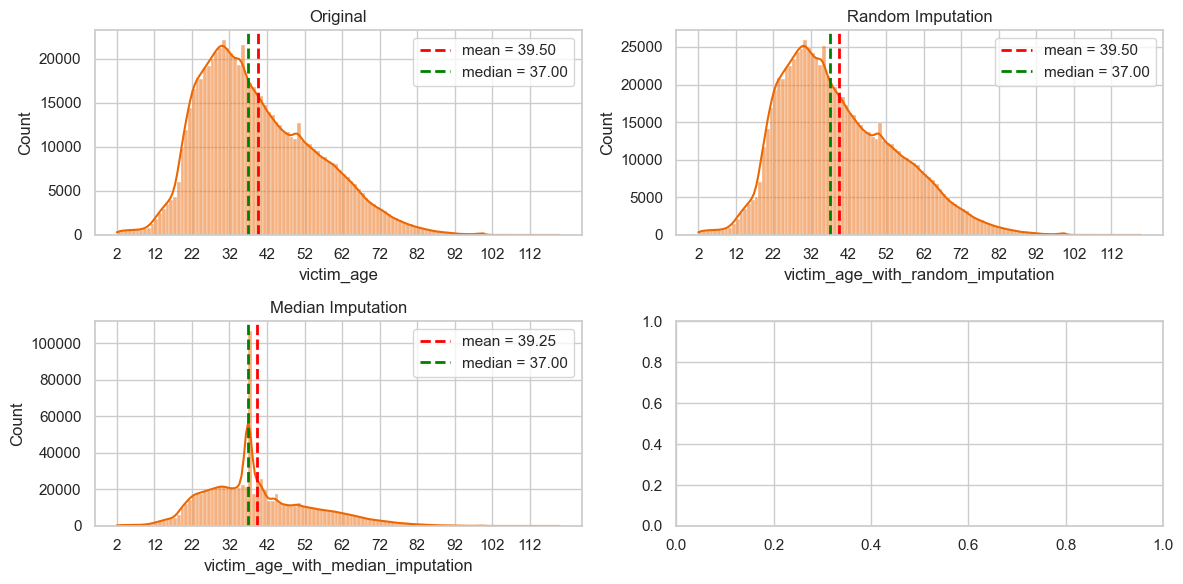

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
plot_histogram(df.victim_age, ax=ax[0, 0], title='Original', gap=10)
plot_histogram(df.victim_age_with_random_imputation, ax=ax[0, 1], title='Random Imputation', gap=10)
plot_histogram(df.victim_age_with_median_imputation, ax=ax[1, 0], title='Median Imputation', gap=10)
plt.tight_layout()
plt.show()

> Here we see that the random sample imputation looks better since the median imputation has a very high peak and also has most likely disturbed the original moments of the distribution.

> Let's keep the victim_age column with random sample imputation and drop the other 2

In [65]:
df = df.drop(columns=['victim_age', 'victim_age_with_median_imputation'])
df = df.rename(columns={'victim_age_with_random_imputation': 'victim_age'})

> Also impute the NaN values in victim_sex using the same random sample imputation technique.

In [66]:
df['victim_sex_imputed'] = impute_random(df.victim_sex, random_seed=RANDOM_SEED)
df.victim_sex_imputed.isna().mean()

np.float64(0.0)

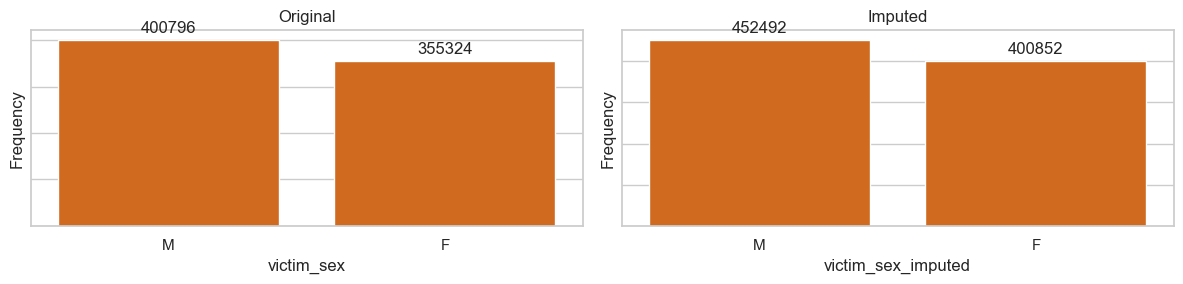

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_top_categories(df.victim_sex, ax=ax[0], title='Original')
plot_top_categories(df.victim_sex_imputed, ax=ax[1], title='Imputed')
plt.tight_layout()
plt.show()

In [68]:
df = df.drop(columns=['victim_sex'])
df = df.rename(columns={'victim_sex_imputed': 'victim_sex'})

> Similarly impute the victim_descent column using the random sample imputation.

In [69]:
df.victim_descent = impute_random(df.victim_descent, random_seed=RANDOM_SEED)
df.is_victim_descent_imputed.isna().mean()

np.float64(0.0)

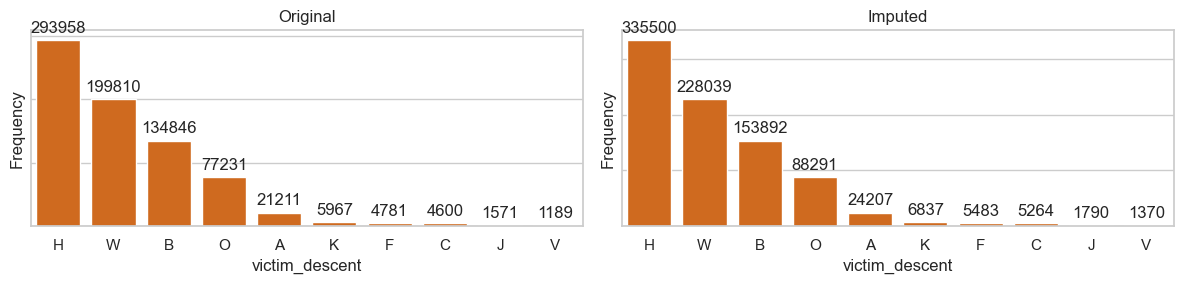

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_top_categories(df.loc[~df.is_victim_descent_imputed, 'victim_descent'], ax=ax[0], title='Original')
plot_top_categories(df.victim_descent, ax=ax[1], title='Imputed')
plt.tight_layout()
plt.show()

In [71]:
show_missing_values(df[['victim_age']])

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,victim_age,2.0,120.0,99,0,0.0%,float64


> Convert the dtypes for these columns accordingly, victim_sex and victim_descent should be converted to 'category(str)' since very high cardinality and 'victim_age' can be converted to 'uint8' since the range is only from 2 to 120.

In [72]:
df.victim_descent = df.victim_descent.astype('category')
df.victim_age = df.victim_age.astype('uint8')
df.victim_sex = df.victim_sex.astype('category')
show_missing_values(df[['mocodes', 'victim_age', 'victim_sex', 'victim_descent']])

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,mocodes,nan,nan,310837,0,0.0%,object
2,victim_age,2,120,99,0,0.0%,uint8
3,victim_sex,nan,nan,2,0,0.0%,category
4,victim_descent,nan,nan,18,0,0.0%,category


In [73]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,report_number,10304468,252104053,853344,0,0.0%,int64
2,date_reported,nan,nan,1860,0,0.0%,datetime64[ns]
3,area_code,nan,nan,21,0,0.0%,category
4,area_name,nan,nan,21,0,0.0%,object
5,report_district_number,nan,nan,1199,0,0.0%,category
6,part,nan,nan,2,0,0.0%,category
7,crime_code,110,956,139,0,0.0%,int64
8,crime_description,nan,nan,139,0,0.0%,object
9,mocodes,nan,nan,310837,0,0.0%,object


#### premises_code

In [74]:
df.premises_code.nunique()

314

> Since it is a categorical column with low cardinality convert from float64 to category(int).

In [75]:
df.premises_code = df.premises_code.astype(int).astype('category')

> premises_code has no missing values while premises_description has 570 missing values, which means there are some codes which have no description, so replace these descriptions with "NOT AVAILABLE"

In [76]:
df.premises_description.head()

0               BUS STOP/LAYOVER (ALSO QUERY 124)
1    MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)
2                                  CLOTHING STORE
3                                          STREET
4                                  PUBLIC STORAGE
Name: premises_description, dtype: object

In [77]:
df.premises_description = df.premises_description.fillna('NOT AVAILABLE')

#### weapon_code & weapon_description

> weapon_code and weapon_description are one of those columns that have more than 50% of the data missing, in such cases, I would generally delete the whole column since imputation is very risky and deletion is not possible, but in this case, I noticed that there are no "NO WEAPON" category in the available data which is a bit strange, my expectataion was to have "NO WEAPON" for a good number of cases if not the most, could it be that NaN values actually just mean "NO WEAPON"? Let's try to find out!

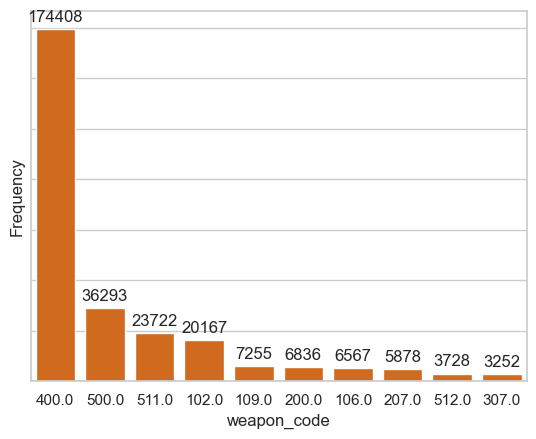

In [78]:
plot_top_categories(df.weapon_code)

> None of the categories in top 10 are "NO WEAPON" with "STRONG ARM" and "OTHER WEAPON" are the top 2 categories.

In [79]:
df[['weapon_code', 'weapon_description']].value_counts().head(10)

weapon_code  weapon_description                            
400.0        STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    174408
500.0        UNKNOWN WEAPON/OTHER WEAPON                        36293
511.0        VERBAL THREAT                                      23722
102.0        HAND GUN                                           20167
109.0        SEMI-AUTOMATIC PISTOL                               7255
200.0        KNIFE WITH BLADE 6INCHES OR LESS                    6836
106.0        UNKNOWN FIREARM                                     6567
207.0        OTHER KNIFE                                         5878
512.0        MACE/PEPPER SPRAY                                   3728
307.0        VEHICLE                                             3252
Name: count, dtype: int64

In [80]:
df.loc[df.weapon_description.str.contains('no ', case=False, na=False), 'weapon_description']

Series([], Name: weapon_description, dtype: object)

> Also there is no description with "no " case-insensitively in it.

> After seeing some random samples for missing values, I see that they are mostly low level crimes.

In [81]:
df[df.weapon_code.isna()].sample(3)

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_code,crime_description,mocodes,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,crime_code_1,crime_code_2,crime_code_3,crime_code_4,location,cross_street,latitude,longitude,datetime_occurred,time_occurred_float,is_victim_age_imputed,is_victim_sex_imputed,is_victim_descent_imputed,victim_age,victim_sex
534643,220312932,2022-06-28,3,Southwest,363,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",1822 0329 1307,B,122,"VEHICLE, PASSENGER/TRUCK",NaN,NaN,IC,Invest Cont,740.0,NaN,NaN,NaN,MARTIN LUTHER KING JR BL,CRENSHAW BL,34.0124,-118.3351,2022-06-27 04:00:00,4.0,False,False,False,43,M
736827,231309723,2023-04-24,13,Newton,1351,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0325 0344 1822,H,405,CLOTHING STORE,NaN,NaN,IC,Invest Cont,442.0,NaN,NaN,NaN,4000 S MAIN ST,NaN,34.0075,-118.2775,2023-04-24 18:54:00,18.9,False,False,False,23,F
59217,200409470,2020-06-03,4,Hollenbeck,429,2,940,EXTORTION,1915,O,501,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,940.0,NaN,NaN,NaN,5300 HYDE ST,NaN,34.0820,-118.1671,2020-06-03 07:00:00,7.0,False,False,False,33,M


> I found this [Article](https://bjs.ojp.gov/content/pub/pdf/wuvc01.pdf) on the internet and it confirms my hunch, according to this article, 69% of all assaults were done by without weapon, here we have almost 62% missing values, i think it is safe to assume that these NaN values actually mean "NO WEAPON".

> Add a new category in weapon_code (let's say 0) and its description to be "NO WEAPON". But first confirm that 0 code is not already present in weapon_code list. Also make sure that the values of weapon_description is only exactly missing when weapon_code is missing. Otherwise we will allocate wrong description. 

In [82]:
df.weapon_code.fillna(-999).astype(int).isin([0]).sum()

np.int64(0)

In [83]:
df.loc[df.weapon_code.isna(), 'weapon_description'].value_counts()

Series([], Name: count, dtype: int64)

In [84]:
df.weapon_code = df.weapon_code.fillna(0).astype(int).astype('category')
df.loc[df.weapon_code == 0, 'weapon_description'] = 'NO WEAPON'
df.weapon_code.isna().mean(), df.weapon_description.isna().mean()

(np.float64(0.0), np.float64(0.0))

In [85]:
show_missing_values(df[['status_code', 'status_description']])

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,status_code,nan,nan,6,0,0.0%,object
2,status_description,nan,nan,6,0,0.0%,object


#### status_code

> Categorical with very low cardinality so convert it from object to category(str)

In [86]:
df.status_code = df.status_code.astype('category')

#### cross_street

In [87]:
df.loc[df.cross_street.notna(), ['cross_street', 'location', 'area_name']].sample(5)

,cross_street,location,area_name
46507,MONTANA,LIBERTY,Northeast
649011,SAN VICENTE,LONGWOOD AV,Wilshire
202264,MELROSE AV,SIERRA BONITA AV,Wilshire
223047,KNOWLTON ST,LA CIENEGA,Pacific
170391,WILSHIRE,HOBART,Olympic


In [88]:
df.loc[df.cross_street.isna(), ['cross_street', 'location', 'area_name']].sample(5)

,cross_street,location,area_name
181638,NaN,100 E 5TH ST,Central
532992,NaN,19800 SIERRA MEADOWS LN,Devonshire
319263,NaN,23200 COLLINS ST,Topanga
216845,NaN,4500 BOWMAN BL,Hollenbeck
670381,NaN,5000 S CENTINELA AV,Pacific


> I don't think cross_street column would be helpful in any ways and also 85% of the missing values, there is no reason just not to drop this column.

In [89]:
df = df.drop(columns=['cross_street'])

In [90]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,report_number,10304468,252104053,853344,0,0.0%,int64
2,date_reported,nan,nan,1860,0,0.0%,datetime64[ns]
3,area_code,nan,nan,21,0,0.0%,category
4,area_name,nan,nan,21,0,0.0%,object
5,report_district_number,nan,nan,1199,0,0.0%,category
6,part,nan,nan,2,0,0.0%,category
7,crime_code,110,956,139,0,0.0%,int64
8,crime_description,nan,nan,139,0,0.0%,object
9,mocodes,nan,nan,310837,0,0.0%,object


> The data looks data, only the crime_code columns have the missing values and wrong dtypes which we are going to address in the next phase of data explosion.

### Data Explosion

When a data point (in our case a specific report) can have multiple values for a variable like multiple crime codes for a specific report number or multiple mocodes, it is very difficult to save this record. There are usually 3 ways to save this type of data:

1. Multiple Columns: You add new column everytime you get an additional value, for example in case of crime_code, they might have just started with only one column, when they got the first case with 2 crime codes, they added another column with the name crime_code_2, then 3rd and 4th, where 2nd, 3rd and 4th crime_code columns are mostly empty. This is a very bad approach since you can't always add a new column everytime you get an additional value and even if you do, most of the column will be empty. Also you can't use this type of structure for any type of data analysis.

2. Multiple values in a single column: Since we know that adding a new column is very inefficient and for large number of values is almost impossible, the other way to save multiple values is to have a list in each cell, with list containing all the values, this is already a better solution then the first one but still can not be used for any data analysis.

3. Data Explosion: We repeat the row everytime we get a new value for any variable, for example if we have 2 crime codes for a report_number, we repeat the row 2 times with all the same fields except one time we have one crime code and the second time we have the second crime code. This process is called data explosion and it can make our data size huge, example if 4 columns are being exploded, the size will almost be 4 times more. But the benefit is after doing this, we will be able to perform any kind of data analysis in almost all the data exploration tools. This step will also make our data structure closer to the 1st Normal Form of the relational database but not exactly (It is also irrelevant in our scenerio just interesting to know).

1NF -> Primary Key, Atomic Values and df = # variables

In [91]:
df[['crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4']].notna().sum(axis=1).value_counts()

1    784471
2     66560
3      2249
4        64
Name: count, dtype: int64

> In order to explode based on the crime_codes we need to have all the crime_codes in a single column as a list, but first I thought it would be a useful additional feature that we can see the number_of_crimes for each report, so I am summing the crimes (on axis=1 mean by row) and then merging the columns to a new column named 'crime_codes' as a list and then dropping the previous columns.

In [92]:
df['number_of_crimes'] = df[['crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4']].notna().sum(axis=1)
df['crime_codes'] = df[['crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4']].values.tolist()
df = df.drop(columns=['crime_code', 'crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4'])
df.head()

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_description,mocodes,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,location,latitude,longitude,datetime_occurred,time_occurred_float,is_victim_age_imputed,is_victim_sex_imputed,is_victim_descent_imputed,victim_age,victim_sex,number_of_crimes,crime_codes
0,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1822 1402 0344,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.000000,False,False,False,47,M,2,"[330.0, 998.0, nan, nan]"
1,200320258,2020-11-11,3,Southwest,356,1,BIKE - STOLEN,0344 1251,B,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0,NO WEAPON,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020-11-04 17:00:00,17.000000,False,True,True,19,M,1,"[480.0, nan, nan, nan]"
2,200907217,2023-05-10,9,Van Nuys,964,1,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,O,405,CLOTHING STORE,0,NO WEAPON,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020-03-10 20:37:00,20.616667,False,False,False,19,M,1,"[343.0, nan, nan, nan]"
3,200200759,2020-07-07,2,Rampart,265,1,ARSON,0329 1402 2004 1501,W,101,STREET,0,NO WEAPON,IC,Invest Cont,JAMES M WOOD,34.0536,-118.2788,2020-07-07 13:40:00,13.666667,True,True,True,35,F,2,"[648.0, 998.0, nan, nan]"
4,200406391,2020-03-02,4,Hollenbeck,407,1,BURGLARY,0344 1607,W,221,PUBLIC STORAGE,0,NO WEAPON,IC,Invest Cont,4500 HUNTINGTON DR,34.0881,-118.1877,2020-03-01 14:30:00,14.500000,False,False,False,27,M,1,"[310.0, nan, nan, nan]"


> For mocodes, the values are already in a single column but they are just separated by a space, so let's convert them into a list as well by using the vector str method `.split()`, default argument is a space.

In [93]:
df.loc[df.mocodes.notna(), 'mocodes'] = df.loc[df.mocodes.notna(), 'mocodes'].str.split()

df.mocodes.head()

0          [1822, 1402, 0344]
1                [0344, 1251]
2                [0325, 1501]
3    [0329, 1402, 2004, 1501]
4                [0344, 1607]
Name: mocodes, dtype: object

> Now we have both the columns ready to be exploded. Note that since in crime_codes we are exactly exploding based on the 4 values each, our exploded dataframe will have the rows 4 times more than the current dataframe.

In [94]:
df.shape, df.shape[0] * 4

((853344, 27), 3413376)

#### crime codes Explosion

> Now let's explode the crime_codes column, ignore_index argument means to reset the index and .copy() is a deep copy since I want to keep the original non exploded dataset as it is.

In [95]:
df_exploded = df.explode('crime_codes', ignore_index=True).copy()
df_exploded.shape

(3413376, 27)

> Now drop the rows where the crime_code is NaN and again reset the index. Convert the column name from 'crime_codes' to 'crime_code' and also convert the type from float64 to category(int) since it is categorical with relatively low cardinality.

In [96]:
df_exploded = df_exploded.dropna(subset=['crime_codes'], ignore_index=True)
df_exploded = df_exploded.rename(columns={'crime_codes': 'crime_code'})
df_exploded.crime_code = df_exploded.crime_code.astype(int).astype('category')
df_exploded.head(3)

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_description,mocodes,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,location,latitude,longitude,datetime_occurred,time_occurred_float,is_victim_age_imputed,is_victim_sex_imputed,is_victim_descent_imputed,victim_age,victim_sex,number_of_crimes,crime_code
0,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,"[1822, 1402, 0344]",O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330
1,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,"[1822, 1402, 0344]",O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,998
2,200320258,2020-11-11,3,Southwest,356,1,BIKE - STOLEN,"[0344, 1251]",B,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0,NO WEAPON,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020-11-04 17:00:00,17.0,False,True,True,19,M,1,480


> Now explode the mocodes and repeat the same steps.

In [97]:
df_exploded = df_exploded.explode('mocodes', ignore_index=True)
df_exploded = df_exploded.rename(columns={'mocodes': 'modus_operandi_code'})
df_exploded = df_exploded.dropna(subset=['modus_operandi_code'], ignore_index=True)
df_exploded.modus_operandi_code = df_exploded.modus_operandi_code.astype(int).astype('category')
df_exploded.head(3)

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_description,modus_operandi_code,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,location,latitude,longitude,datetime_occurred,time_occurred_float,is_victim_age_imputed,is_victim_sex_imputed,is_victim_descent_imputed,victim_age,victim_sex,number_of_crimes,crime_code
0,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1822,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330
1,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1402,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330
2,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,344,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330


In [98]:
df_exploded.modus_operandi_code.dtype

CategoricalDtype(categories=[ 100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
                  ...
                  4013, 4015, 4016, 4019, 4021, 4024, 4025, 4026, 4027, 9999],
, ordered=False, categories_dtype=int64)

> Since we have no description for mocodes, I found this dataset online [here](https://data.lacity.org/api/views/d5tf-ez2w/files/8957b3b1-771a-4686-8f19-281d23a11f1b?download=true&filename=MO_CODES_Numerical_20180627.pdf). I have parsed the pdf values in a csv file here -> [mocodes.csv](data/mocodes.csv)

> We could do a many-to-one merge (left) merge on our df_exploded, the foriegn key will be 'modus_operandi_code' as left_on argument and the primary key will be 'mocodes' as the right_on argument. Also since it will repeat the mocodes column, drop it from the returned df and rename the description to be mocode_description.

> There are some mocodes that do not have any description in our outside dataset, so we will replace these descriptions with "DESCRIPTION NOT AVAILABLE".

In [99]:
df_mocode.head()

,mocodes,description
0,1243,Co-habitants
1,1244,Victim was forced into business
2,1245,Victim was forced into residence
3,1247,Opening business
4,1248,Closing business


In [100]:
df_exploded = (df_exploded
    .merge(df_mocode, how='left', left_on='modus_operandi_code', right_on='mocodes', validate='m:1')
    .drop(columns=['mocodes'])
    .rename(columns={'description': 'mocode_description'})
)
df_exploded.mocode_description = df_exploded.mocode_description.fillna('DESCRIPTION NOT AVAILABLE')
df_exploded.head()

,report_number,date_reported,area_code,area_name,report_district_number,part,crime_description,modus_operandi_code,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_description,location,latitude,longitude,datetime_occurred,time_occurred_float,is_victim_age_imputed,is_victim_sex_imputed,is_victim_descent_imputed,victim_age,victim_sex,number_of_crimes,crime_code,mocode_description
0,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1822,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330,Stranger
1,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1402,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330,Evidence Booked (any crime)
2,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,344,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,330,DESCRIPTION NOT AVAILABLE
3,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1822,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,998,Stranger
4,200106753,2020-02-09,1,Central,182,1,BURGLARY FROM VEHICLE,1402,O,128,BUS STOP/LAYOVER (ALSO QUERY 124),0,NO WEAPON,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020-02-08 18:00:00,18.0,False,False,False,47,M,2,998,Evidence Booked (any crime)


In [101]:
df_exploded.modus_operandi_code.dtype

dtype('int64')

> The merging process has upcasted the dtype of modus_operandi_code from category(int64) to int64, since in order to compare 2 columns to merge on them, Pandas by default upcast one of the column to have them the same dtype and since in our case the dtype of df_mocode.mocodes was int64 and df_exploded.modus_operandi_code was category(int64), so it was upcasted accordingly.

> Let's downcast it again to 'category(int)' dtype.

In [102]:
df_exploded.modus_operandi_code = df_exploded.modus_operandi_code.astype('category')

In [103]:
show_missing_values(df_exploded)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,report_number,10304468,252104053,853344,0,0.0%,int64
2,date_reported,nan,nan,1860,0,0.0%,datetime64[ns]
3,area_code,nan,nan,21,0,0.0%,category
4,area_name,nan,nan,21,0,0.0%,object
5,report_district_number,nan,nan,1199,0,0.0%,category
6,part,nan,nan,2,0,0.0%,category
7,crime_description,nan,nan,139,0,0.0%,object
8,modus_operandi_code,nan,nan,739,0,0.0%,category
9,victim_descent,nan,nan,18,0,0.0%,category


> Since there are no missing values and no unnecessary float objects, the data is ready to be exported for further analysis...

> I would import it both of the dataframes, one with explosion and one without explosion, since in certain scenerios the dataframe without explosion would be helpful for example when we are more concerned about the variables other than the exploded variables.

> Also I am exporting the data as the pandas' native pickle format for efficiency. It will preserve the datatypes and all the formatting that we did in the dataframes. If we instead export these as csv, we will lose all the formatting (dtypes) information. Also it is very efficient as compared to csvs.

In [104]:
df_exploded.to_pickle('data/exploded_crime_data.pkl')
df.to_pickle('data/crime_data.pkl')